In [1]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("census-income").config("spark-master", "local").getOrCreate()
spark

### Set up schema and read data from CSV

In [3]:
from pyspark.sql.types import *
struct_fields_list = [
    StructField("age", IntegerType(), True),
    StructField("class_of_worker", StringType(), True),
    StructField("industry_code", StringType(), True),
    StructField("occupation_code", StringType(), True),
    StructField("education", StringType(), True),
    StructField("wage_per_hr", DoubleType(), True),
    StructField("enrolled_in_edu_inst_last_wk", StringType(), True),
    StructField("marital_status", StringType(), True),
    StructField("major_industry_code", StringType(), True),
    StructField("major_occupation_code", StringType(), True),
    StructField("race", StringType(), True),
    StructField("hispanic_origin", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("mem_labour_union", StringType(), True),
    StructField("unemployment_reason", StringType(), True),
    StructField("employment_status", StringType(), True),
    StructField("capital_gain", DoubleType(), True),
    StructField("capital_loss", DoubleType(), True),
    StructField("stock_dividends", DoubleType(), True),
    StructField("tax_filer_status", StringType(), True),
    StructField("prev_region", StringType(), True),
    StructField("prev_state", StringType(), True),
    StructField("household_status", StringType(), True),
    StructField("household_summary", StringType(), True),
    StructField("instance_weight", DoubleType(), True),
    StructField("migration_code_msa", StringType(), True),
    StructField("migration_code_region", StringType(), True),
    StructField("migration_code_within_region", StringType(), True),
    StructField("live_in_this_house_one_year_ago", StringType(), True),
    StructField("migration_prev_res_in_sunbelt", StringType(), True),
    StructField("num_persons_for_employer", IntegerType(), True),
    StructField("parent", StringType(), True),
    StructField("birth_country_father", StringType(), True),
    StructField("birth_country_mother", StringType(), True),
    StructField("birth_country_self", StringType(), True),
    StructField("citizenship", StringType(), True),
    StructField("own_business", StringType(), True),
    StructField("veteran_QA", StringType(), True),
    StructField("veteran_benefits", StringType(), True),
    StructField("weeks_worked_in_yr", IntegerType(), True),
    StructField("year", StringType(), True),
    StructField("income", StringType(), True),
]

schema = StructType(struct_fields_list)

# read data, remove trailing and leading whitespace, set null value to ?
spark_train = spark.read.csv("census-income.data", 
                             schema=schema, 
                             ignoreLeadingWhiteSpace=True,
                             ignoreTrailingWhiteSpace=True,
                             nullValue="?")
spark_test = spark.read.csv("census-income.test", 
                             schema=schema, 
                             ignoreLeadingWhiteSpace=True,
                             ignoreTrailingWhiteSpace=True,
                             nullValue="?")

TRAIN_SIZE = spark_train.count()
TEST_SIZE = spark_test.count()

print("Train set shape: ({},{})".format(TRAIN_SIZE, len(spark_train.columns)))
print("Test set shape: ({}, {})".format(TEST_SIZE, len(spark_test.columns)))

Train set shape: (199523,42)
Test set shape: (99762, 42)


In [4]:
# Get full dataset 
spark_ds = spark_train.union(spark_test)
# Drop instance_weight column (according to dataset description)
spark_ds = spark_ds.drop("instance_weight")
DATASET_SIZE = spark_ds.count()
# Full dataset shape
print("Dataset shape: ({}, {})".format(DATASET_SIZE, len(spark_ds.columns)))
print()
# Print first 5 rows
spark_ds.show(5, truncate=False, vertical=True)

Dataset shape: (299285, 41)

-RECORD 0-------------------------------------------------------------------
 age                             | 73                                       
 class_of_worker                 | Not in universe                          
 industry_code                   | 0                                        
 occupation_code                 | 0                                        
 education                       | High school graduate                     
 wage_per_hr                     | 0.0                                      
 enrolled_in_edu_inst_last_wk    | Not in universe                          
 marital_status                  | Widowed                                  
 major_industry_code             | Not in universe or children              
 major_occupation_code           | Not in universe                          
 race                            | White                                    
 hispanic_origin                 | All other   

In [5]:
target_col = "income"
nominal_cols = [x[0] for x in spark_ds.dtypes if x[1] == "string" and x[0] != target_col]
numeric_cols = [x[0] for x in spark_ds.dtypes if x[1] != "string" and x[0] != target_col]

print("Nominal columns:", nominal_cols)
print("There are {} nominal columns.".format(len(nominal_cols)))
print()
print("Numeric columns:", numeric_cols)
print("There are {} numeric columns.".format(len(numeric_cols)))

Nominal columns: ['class_of_worker', 'industry_code', 'occupation_code', 'education', 'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'mem_labour_union', 'unemployment_reason', 'employment_status', 'tax_filer_status', 'prev_region', 'prev_state', 'household_status', 'household_summary', 'migration_code_msa', 'migration_code_region', 'migration_code_within_region', 'live_in_this_house_one_year_ago', 'migration_prev_res_in_sunbelt', 'parent', 'birth_country_father', 'birth_country_mother', 'birth_country_self', 'citizenship', 'own_business', 'veteran_QA', 'veteran_benefits', 'year']
There are 33 nominal columns.

Numeric columns: ['age', 'wage_per_hr', 'capital_gain', 'capital_loss', 'stock_dividends', 'num_persons_for_employer', 'weeks_worked_in_yr']
There are 7 numeric columns.


### Empty values preprocessing

In [6]:
from pyspark.sql.functions import *

# Count null and empty values in each columns
# In numeric columns
print("Empty values percentage in numeric columns:")
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == ""), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in numeric_cols]).show(vertical=True)
# In nominal columns
print("Empty values percentage in nominal columns:")
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == ""), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in nominal_cols]).show(vertical=True)

Empty values percentage in numeric columns:
-RECORD 0-----------------------
 age                      | 0.0 
 wage_per_hr              | 0.0 
 capital_gain             | 0.0 
 capital_loss             | 0.0 
 stock_dividends          | 0.0 
 num_persons_for_employer | 0.0 
 weeks_worked_in_yr       | 0.0 

Empty values percentage in nominal columns:
-RECORD 0---------------------------------------------
 class_of_worker                 | 0.0                
 industry_code                   | 0.0                
 occupation_code                 | 0.0                
 education                       | 0.0                
 enrolled_in_edu_inst_last_wk    | 0.0                
 marital_status                  | 0.0                
 major_industry_code             | 0.0                
 major_occupation_code           | 0.0                
 race                            | 0.0                
 hispanic_origin                 | 0.0                
 sex                             | 0.0    

We can see that all numeric columns do not have empty values. Let's inspect nominal columns which have empty values and process them.

In [7]:
# Inspect columns with empty counts
cols_with_empty_vals = ["prev_state", "migration_code_msa", "migration_code_region", "migration_code_within_region",
                       "migration_prev_res_in_sunbelt", "birth_country_father", "birth_country_mother", "birth_country_self"]

We can see from the output above that 4 columns (which start with migration_code*) have a really high percentage of missing values compared to all other columns (around 50% data missing). We will drop these columns because it might be misleading to include these columns in our classifier.

In [8]:
# Notice that 4 columns: migration_code_* have a really high percentage of null values, ~50%
# Inspect a sample migration_code_* column's unique values count
print("Unique values count of migration_code_msa column:")
spark_ds.groupBy("migration_code_msa")\
        .count()\
        .withColumn("count", col("count") / DATASET_SIZE * 100)\
        .orderBy(desc("count")).show()

# We will drop these columns
redundant_cols = ["migration_code_msa", "migration_code_region", "migration_code_within_region",
                         "migration_prev_res_in_sunbelt"]

spark_ds = spark_ds.drop(*redundant_cols)
cols_with_empty_vals = [c for c in cols_with_empty_vals if c not in redundant_cols]
nominal_cols = [c for c in nominal_cols if c not in redundant_cols]

print("Total number of columns after dropping:", len(spark_ds.columns))

Unique values count of migration_code_msa column:
+------------------+-------------------+
|migration_code_msa|              count|
+------------------+-------------------+
|              null|  49.99983293516214|
|          Nonmover| 41.411029620595755|
|        MSA to MSA| 5.3093205473044085|
|  NonMSA to nonMSA|  1.388308802646307|
|   Not in universe| 0.7481163439530882|
|     MSA to nonMSA| 0.3855856457891308|
|     NonMSA to MSA| 0.3040580049117062|
|  Not identifiable| 0.2105016957081043|
|     Abroad to MSA|0.20682626927510567|
|  Abroad to nonMSA|0.03642013465425931|
+------------------+-------------------+

Total number of columns after dropping: 37


In [9]:
# helper function to get unique values percentage in each column
def get_unique_values_percentage(col_name):
    return spark_ds.groupBy(col_name)\
                    .count()\
                    .withColumn("count", col("count") / DATASET_SIZE * 100)\
                    .orderBy(desc("count"))

# helper function to get most frequent value from unique value counts list
def get_most_freq_value(unique_counts, col_name):
    return unique_counts\
            .orderBy(desc("count"))\
            .select(col_name)\
            .collect()[0][col_name]

# helper function to replace null values in column with new specified value
def replace_nulls(col_name, new_value):
    return spark_ds.withColumn(col_name, \
         when(col(col_name).isNull(), new_value).otherwise(col(col_name)))

For remaining columns with lower percentage of null values, our strategy is to replace null values with the most frequent value in each corresponding column. 

In [10]:
# Deal wih remaining columns with empty values but smaller percentage
prev_state_count = get_unique_values_percentage("prev_state")

birth_country_father_count = get_unique_values_percentage("birth_country_father")

birth_country_mother_count = get_unique_values_percentage("birth_country_mother")

birth_country_self_count = get_unique_values_percentage("birth_country_self")

print("prev_state column unique values count:")
prev_state_count.show()
print("birth_country_father column unique values count:")
birth_country_father_count.show()
print("birth_country_mother column unique values count:")
birth_country_mother_count.show()
print("birth_country_self column unique values count:")
birth_country_self_count.show()

# We will replace null values with the most frequent value in each column
prev_state_most_freq = get_most_freq_value(prev_state_count, "prev_state")
print("Most frequent value in prev_state column:", prev_state_most_freq)

birth_country_father_most_freq = get_most_freq_value(birth_country_father_count, "birth_country_father")
print("Most frequent value in birth_country_father column:", birth_country_father_most_freq)

birth_country_mother_most_freq = get_most_freq_value(birth_country_mother_count, "birth_country_mother")
print("Most frequent value in birth_country_mother column:", birth_country_mother_most_freq)

birth_country_self_most_freq = get_most_freq_value(birth_country_self_count, "birth_country_self")
print("Most frequent value in birth_country_self column:", birth_country_self_most_freq)

# Replace null values
spark_ds = replace_nulls("prev_state", prev_state_most_freq)
spark_ds = replace_nulls("birth_country_father", birth_country_father_most_freq)
spark_ds = replace_nulls("birth_country_mother", birth_country_mother_most_freq)
spark_ds = replace_nulls("birth_country_self", birth_country_self_most_freq)

print("Verify results:")
# verify results
get_unique_values_percentage("prev_state").show()
get_unique_values_percentage("birth_country_father").show()
get_unique_values_percentage("birth_country_mother").show()
get_unique_values_percentage("birth_country_self").show()
print("Empty values count:")
spark_ds.select([(count(when((col(c).isNull()) | (col(c) == ""), c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in cols_with_empty_vals]).show(vertical=True)


prev_state column unique values count:
+---------------+-------------------+
|     prev_state|              count|
+---------------+-------------------+
|Not in universe|  92.15897889971097|
|     California|  0.868068897539135|
|           Utah| 0.5336050921362581|
|        Florida| 0.4340344487695675|
| North Carolina|0.40429690762985115|
|           null| 0.3468266034047814|
|         Abroad| 0.3127453764806121|
|       Oklahoma|0.30806756102043203|
|      Minnesota| 0.2903586882068931|
|        Indiana|0.27732763085353423|
|   North Dakota|0.24224401490218353|
|     New Mexico|0.23088360592746046|
|       Michigan| 0.2138429924653758|
|         Alaska|0.13832968575103996|
|        Arizona| 0.1269692767763169|
|  New Hampshire|0.11961842391031959|
|       Kentucky|0.11961842391031959|
|       Colorado|0.11794777553168385|
|         Oregon|0.11560886780159381|
|        Wyoming| 0.1149406084501395|
+---------------+-------------------+
only showing top 20 rows

birth_country_father co

-RECORD 0-------------------
 prev_state           | 0.0 
 birth_country_father | 0.0 
 birth_country_mother | 0.0 
 birth_country_self   | 0.0 



After some inspection, we see that some columns have a really high percentage of "Not in universe" values, which means the value recorded is not in the survey's values domain. We probably do not want to include these columns when we train our classifier. We set the threshold to be 90% (i.e. if the percentage of "Not in universe" values is more than 90% in a specific column, we will drop it).

In [11]:
# Show "Not in universe" percentage count in each column
spark_ds.select([(count(when(col(c) == "Not in universe", c)) / DATASET_SIZE * 100)\
                 .alias(c) for c in nominal_cols]).show(vertical=True)

-RECORD 0--------------------------------------------
 class_of_worker                 | 50.22770937400806 
 industry_code                   | 0.0               
 occupation_code                 | 0.0               
 education                       | 0.0               
 enrolled_in_edu_inst_last_wk    | 93.67893479459379 
 marital_status                  | 0.0               
 major_industry_code             | 0.0               
 major_occupation_code           | 50.44255475550061 
 race                            | 0.0               
 hispanic_origin                 | 0.0               
 sex                             | 0.0               
 mem_labour_union                | 90.46293666571997 
 unemployment_reason             | 96.92600698331022 
 employment_status               | 0.0               
 tax_filer_status                | 0.0               
 prev_region                     | 92.15897889971097 
 prev_state                      | 92.50580550311575 
 household_status           

We can see that these 6 columns have more than 90% of "Not in universe" values. We will drop these columns from our dataset.

In [12]:
high_niu_cols = ['enrolled_in_edu_inst_last_wk', 'mem_labour_union', 'unemployment_reason', 'prev_region', 'prev_state', 'veteran_QA']
# drop these columns
spark_ds = spark_ds.drop(*high_niu_cols)

In [13]:
print("Final dataset shape: ({}, {})".format(DATASET_SIZE, len(spark_ds.columns)))

Final dataset shape: (299285, 31)


### Convert target variable (income) for binary classification problem

In [14]:
# Show percentage of each unique values in our target variable
income_count = get_unique_values_percentage("income")
income_count.show()
# We could see that around 94% of our data belongs to -50000 class (below 50$K dollar income/year)
# This signifies a binary classification problem with imbalanced data
# We will convert major label to be 0 (negative) and minor label to be 1 (positive)
major_label = income_count.orderBy(desc("count"))\
                .select("income")\
                .collect()[0]["income"]
minor_label = income_count.orderBy(desc("count"))\
                .select("income")\
                .collect()[1]["income"]

print("Major label:", major_label)
print("Minor label:", minor_label)

# Convert to numeric
spark_ds = spark_ds.withColumn("income", \
         when(col("income") == minor_label, 1).otherwise(0))
# Convert income column to be numeric type (int)
spark_ds = spark_ds.withColumn("income", col("income").cast("int"))

# verify results
print("Verify results:")
get_unique_values_percentage("income").show()

+--------+-----------------+
|  income|            count|
+--------+-----------------+
|- 50000.|93.79588018109828|
| 50000+.|6.204119818901716|
+--------+-----------------+

Major label: - 50000.
Minor label: 50000+.
Verify results:
+------+-----------------+
|income|            count|
+------+-----------------+
|     0|93.79588018109828|
|     1|6.204119818901716|
+------+-----------------+



## Exploration data analysis

In [15]:
target_col = "income"
nominal_cols = [x[0] for x in spark_ds.dtypes if x[1] == "string" and x[0] != target_col]
numeric_cols = [x[0] for x in spark_ds.dtypes if x[1] != "string" and x[0] != target_col]

print("Nominal columns:", nominal_cols)
print("There are {} nominal columns.".format(len(nominal_cols)))
print()
print("Numeric columns:", numeric_cols)
print("There are {} numeric columns.".format(len(numeric_cols)))

Nominal columns: ['class_of_worker', 'industry_code', 'occupation_code', 'education', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'employment_status', 'tax_filer_status', 'household_status', 'household_summary', 'live_in_this_house_one_year_ago', 'parent', 'birth_country_father', 'birth_country_mother', 'birth_country_self', 'citizenship', 'own_business', 'veteran_benefits', 'year']
There are 23 nominal columns.

Numeric columns: ['age', 'wage_per_hr', 'capital_gain', 'capital_loss', 'stock_dividends', 'num_persons_for_employer', 'weeks_worked_in_yr']
There are 7 numeric columns.


We will explore numeric columns first, then move on to nominal columns. We will also try to only show columns with meaningful data because the total number of columns might be too large.

### Age

#### General statistics

In [16]:
spark_ds.select("age").describe().show()
median_age = spark_ds.approxQuantile("age", [0.5], 0)[0]
print("Median age:", median_age)

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|            299285|
|   mean|34.538997945102494|
| stddev|22.318468266432593|
|    min|                 0|
|    max|                90|
+-------+------------------+

Median age: 33.0


#### Plot
We will plot histogram labeled by target column (i.e. income).

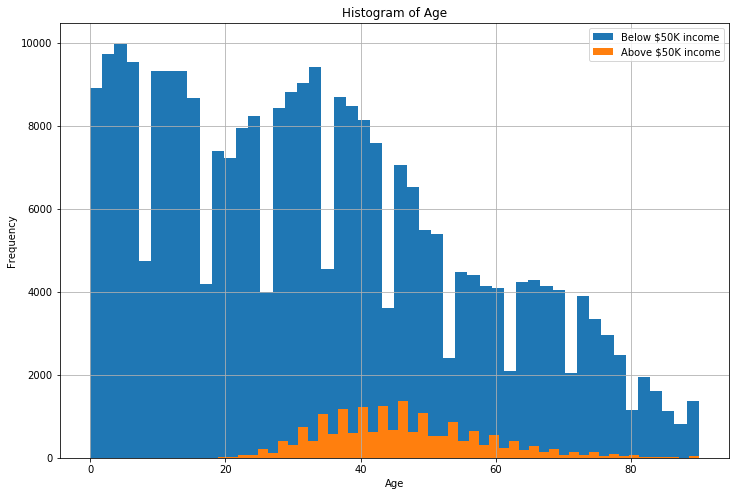

In [17]:
age_0 = spark_ds.where(col("income") == 0).select("age").rdd.flatMap(lambda x: x).collect()
age_1 = spark_ds.where(col("income") == 1).select("age").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.hist(age_0, bins=50, label="Below $50K income")
plt.hist(age_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Age")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

- We can see that people who have above \\$50K income are more than 20 years old (age > 20).
- Most of people who have > \\$50K+ income are from ~30 - ~60 years old.
- The data distribution is slightly right-skewed. You can see that from the point of age 50 onwards, the frequency column's height is almost half.
- More younger people (age < 50) takes part in the survey (census) than older people (age > 50).

### Wage/hr

#### General statistics

In [18]:
# convert to dollars first (original data is in cents unit)
converted_wage_per_hr = spark_ds.select((col("wage_per_hr") / 100).alias("wage_per_hour ($)"))

In [19]:
converted_wage_per_hr.describe().show()
median_wage_per_hr = converted_wage_per_hr.approxQuantile("wage_per_hour ($)", [0.5], 0)[0]
print("Median wage/hr:", median_wage_per_hr)

+-------+------------------+
|summary| wage_per_hour ($)|
+-------+------------------+
|  count|            299285|
|   mean|0.5510502698097132|
| stddev|  2.73340728614754|
|    min|               0.0|
|    max|             99.99|
+-------+------------------+

Median wage/hr: 0.0


#### Plot

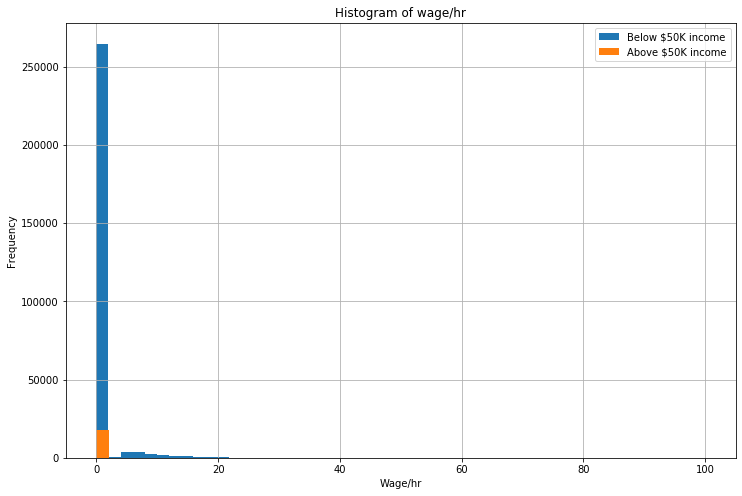

In [20]:
wage_per_hr_0 = spark_ds.where(col("income") == 0).select(col("wage_per_hr") / 100).rdd.flatMap(lambda x: x).collect()
wage_per_hr_1 = spark_ds.where(col("income") == 1).select(col("wage_per_hr") / 100).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.hist(wage_per_hr_0, bins=50, label="Below $50K income")
plt.hist(wage_per_hr_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of wage/hr")
plt.xlabel('Wage/hr')
plt.ylabel('Frequency')
plt.show()

- The data distribution is extremely right skewed. Most of the data's wage per hour is 0, meaning most of the people doing the survey does not have a job. We can also see that most of the people who have low wage/hr (below \\$20/hr) have below \\$50K+ income/yr.
- Interestingly, most of people who have above \$50k+ income (orange part), have wage/hr equals 0. This might mean they have a different source of income other than working or maybe the data might be corrupted.

### Capital loss, capital gain and stock dividends
Like wage/hr column above, these columns also have extremely right-skewed data distribution, i.e. most of the data have value 0.

#### General statistics

In [21]:
spark_ds.select("capital_loss", "capital_gain", "stock_dividends").describe().show()
median_capital_loss = spark_ds.approxQuantile("capital_loss", [0.5], 0)[0]
median_capital_gain = spark_ds.approxQuantile("capital_gain", [0.5], 0)[0]
median_stock_dividends = spark_ds.approxQuantile("stock_dividends", [0.5], 0)[0]
print("Median capital loss:", median_capital_loss)
print("Median capital gain:", median_capital_gain)
print("Median capital stock_dividends:", median_stock_dividends)

+-------+-----------------+------------------+-----------------+
|summary|     capital_loss|      capital_gain|  stock_dividends|
+-------+-----------------+------------------+-----------------+
|  count|           299285|            299285|           299285|
|   mean|36.84901014083566| 431.7421755183187|195.8512588335533|
| stddev|269.7897707879308|4670.7685357730525|1937.847082062182|
|    min|              0.0|               0.0|              0.0|
|    max|           4608.0|           99999.0|          99999.0|
+-------+-----------------+------------------+-----------------+

Median capital loss: 0.0
Median capital gain: 0.0
Median capital stock_dividends: 0.0


#### Plot

In [22]:
capital_loss_0 = spark_ds.where(col("income") == 0).select("capital_loss").rdd.flatMap(lambda x: x).collect()
capital_loss_1 = spark_ds.where(col("income") == 1).select("capital_loss").rdd.flatMap(lambda x: x).collect()
capital_gain_0 = spark_ds.where(col("income") == 0).select("capital_gain").rdd.flatMap(lambda x: x).collect()
capital_gain_1 = spark_ds.where(col("income") == 1).select("capital_gain").rdd.flatMap(lambda x: x).collect()
stock_0 = spark_ds.where(col("income") == 0).select("stock_dividends").rdd.flatMap(lambda x: x).collect()
stock_1 = spark_ds.where(col("income") == 1).select("stock_dividends").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,12))
# Capital loss histogram
plt.subplot(2,2,1)
plt.hist(capital_loss_0, bins=50, label="Below $50K income")
plt.hist(capital_loss_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Capital loss")
plt.xlabel('Capital loss')
plt.ylabel('Frequency')

# Capital gain histogram
plt.subplot(2,2,2)
plt.hist(capital_gain_0, bins=50, label="Below $50K income")
plt.hist(capital_gain_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Capital gain")
plt.xlabel('Capital gain')
plt.ylabel('Frequency')

# Stock dividends histogram
plt.subplot(2,2,3)
plt.hist(stock_0, bins=50, label="Below $50K income")
plt.hist(stock_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Stock dividends")
plt.xlabel('Stock dividends')
plt.ylabel('Frequency')

plt.show()

### Weeks worked in year

#### General statistics

In [23]:
spark_ds.select("weeks_worked_in_yr").describe().show()
median_weeks_worked_in_yr = spark_ds.approxQuantile("weeks_worked_in_yr", [0.5], 0)[0]
print("Median weeks worked in a year:", median_weeks_worked_in_yr)

+-------+------------------+
|summary|weeks_worked_in_yr|
+-------+------------------+
|  count|            299285|
|   mean| 23.17837512738694|
| stddev| 24.40401555222534|
|    min|                 0|
|    max|                52|
+-------+------------------+

Median weeks worked in a year: 8.0


#### Plot

In [24]:
weeks_worked_0 = spark_ds.where(col("income") == 0).select("weeks_worked_in_yr").rdd.flatMap(lambda x: x).collect()
weeks_worked_1 = spark_ds.where(col("income") == 1).select("weeks_worked_in_yr").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.hist(weeks_worked_0, bins=50, label="Below $50K income")
plt.hist(weeks_worked_1, bins=50, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Histogram of Weeks worked in 1 year")
plt.xlabel('Weeks worked in 1 year')
plt.ylabel('Frequency')
plt.show()

- The data distribution is very interesting. Most of the people either do not work (i.e. 0 week) or work for a whole year (i.e. 52 weeks). 
- A smaller number of people works part time during the year (lower frequency bars in the middle of the plot)
- We can clearly see that most of people who have above \$50K+ income/yr works for a whole year (orange part in week 52 bar).

### Scatter plot

#### Age vs Wage/hr

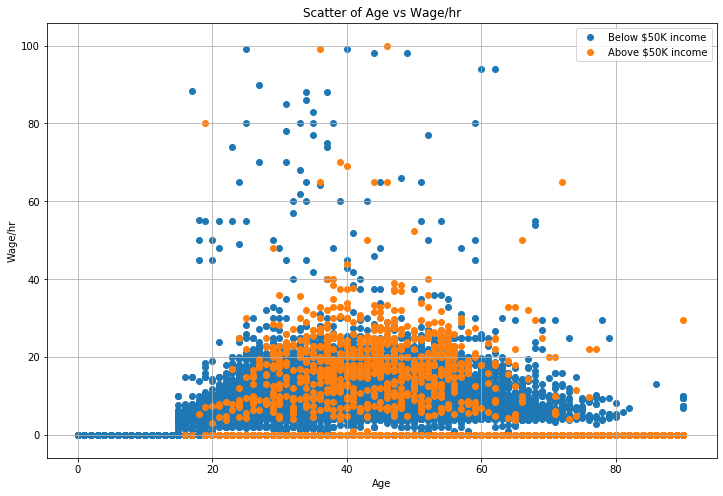

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, wage_per_hr_0, label="Below $50K income")
plt.scatter(age_1, wage_per_hr_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Wage/hr")
plt.xlabel('Age')
plt.ylabel('Wage/hr')
plt.show()

- We can see that most of the people who have above \\$50k+ income have wage/hr < \\$40/hr.
- Above the threshold of \\$40 wage/hr, there are more people (\*) with <50$K+ income than people with >\\$50K+ income. These people (\*) probably worked part time instead of full-time.

####  Age vs Capital gain

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, capital_gain_0, label="Below $50K income")
plt.scatter(age_1, capital_gain_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Capital gain")
plt.xlabel('Age')
plt.ylabel('Capital gain')
plt.show()

- We can see most of the people have capital gain below \\$40K. Capital gain below \\$40K does not necessarily mean that your income will be lower than \\$50K, but really high capital gain as we can see (around \\$100K) will result in >\\$50K+ income.

#### Age vs Capital loss

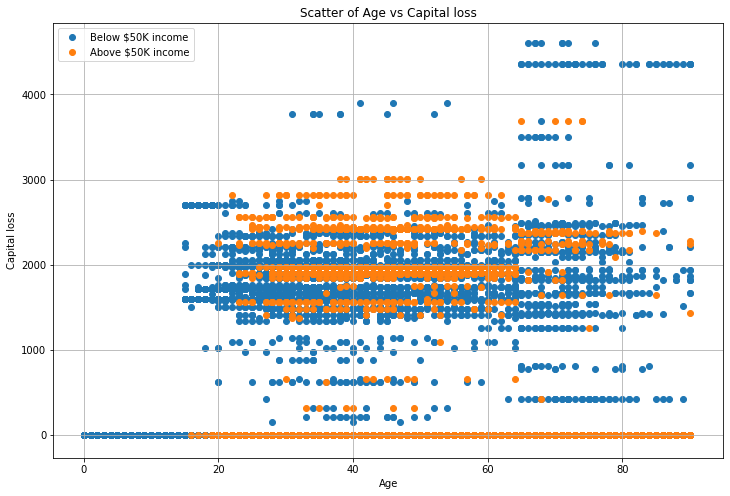

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, capital_loss_0, label="Below $50K income")
plt.scatter(age_1, capital_loss_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Capital loss")
plt.xlabel('Age')
plt.ylabel('Capital loss')
plt.show()

- We can see that almost all people with above $50K+ income have capital loss lower than \\$3000.
- Intuitively, people who have a high capital loss, i.e. above \\$3K, tend to have below \\$50K+ income.

#### Age vs stock dividends

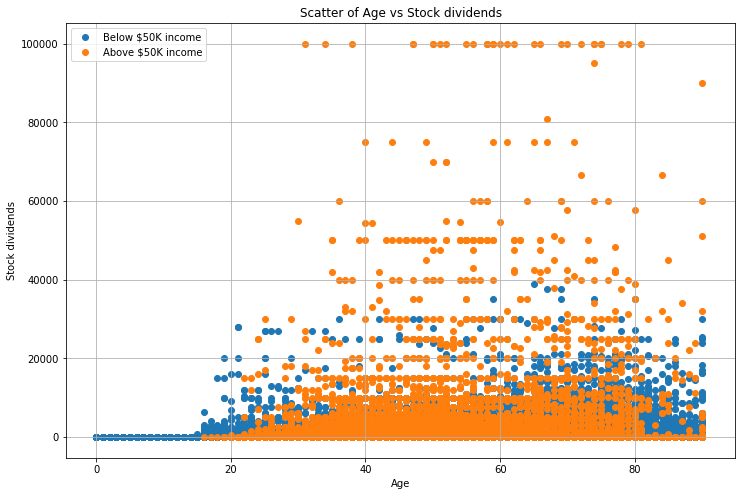

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(age_0, stock_0, label="Below $50K income")
plt.scatter(age_1, stock_1, label="Above $50K income")
plt.legend()
plt.grid()
plt.title("Scatter of Age vs Stock dividends")
plt.xlabel('Age')
plt.ylabel('Stock dividends')
plt.show()

- Below the threshold of \\$40K stock dividends, there are both type of income, either above or below \\$50K.
- Above the threshold of \\$40K stock dividends, there are only people with income above $50K.

### Nominal columns
We will mainly use stacked bar plot labeled by income for nominal columns to visualize our data.

#### Class of worker

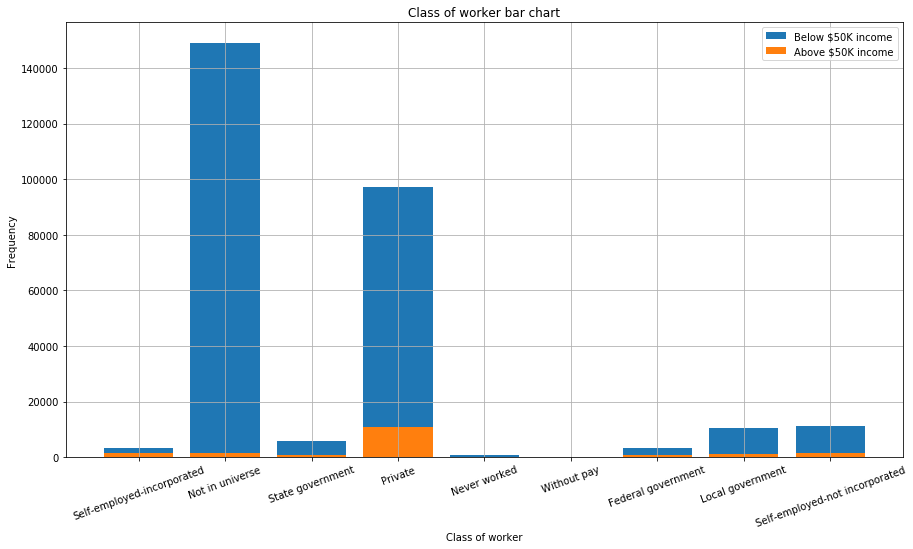

In [29]:
# Query the data
worker_class_count = spark_ds.groupBy('class_of_worker').agg(
    count(when((col("income") == 0), True)).alias("count0"),
    count(when((col("income") == 1), True)).alias("count1")
)

# count rows labeled 0
worker_class_0_count = [row['count0'] for row in worker_class_count.collect()]
# count rows label 1
worker_class_1_count = [row['count1'] for row in worker_class_count.collect()]
# unique labels
worker_class_labels = [row['class_of_worker'] for row in worker_class_count.collect()]
index = np.arange(len(worker_class_labels))

# Plot the bar chart
plt.figure(figsize=(15,8))
plt.bar(index, worker_class_0_count, label="Below $50K income")
plt.bar(index, worker_class_1_count, label="Above $50K income")
plt.xticks(index, worker_class_labels, rotation=20)
plt.legend()
plt.grid()
plt.title("Class of worker bar chart")
plt.xlabel('Class of worker')
plt.ylabel('Frequency')
plt.show()

- It seems like the value "Not in universe" has the highest frequency in this column. Let's ignore that for now.
- Most people have "Private" class of worker, and the number of people with > \\$50k+ income mostly come from this category as well (the highest orange part in Private bar).

#### Education

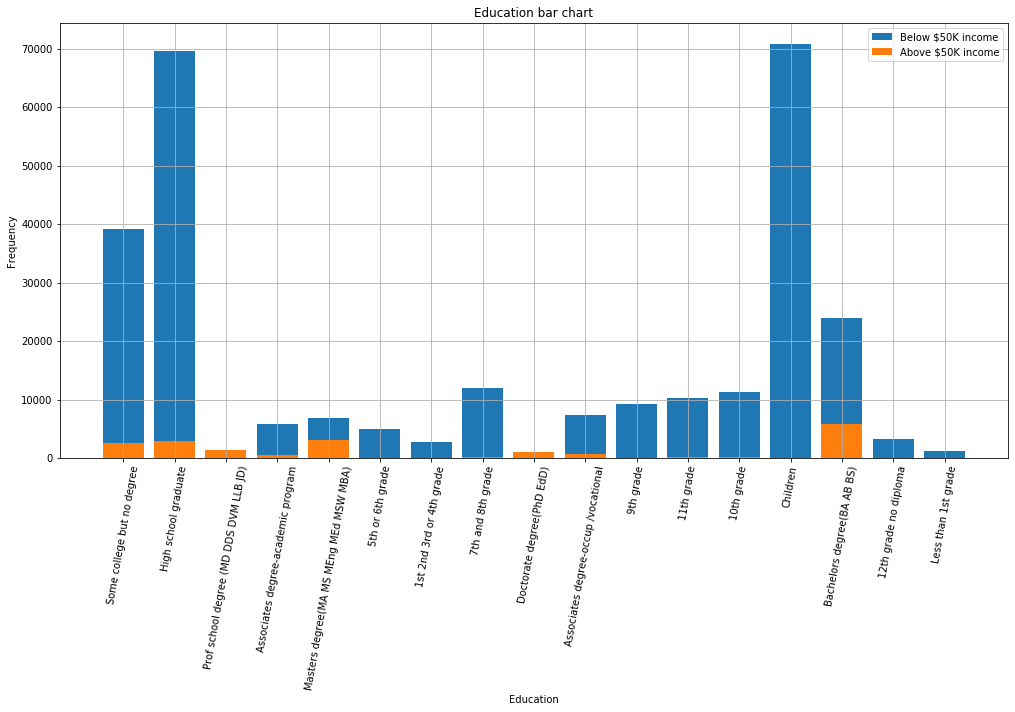

In [30]:
# Query the data
education_count = spark_ds.groupBy('education').agg(
    count(when((col("income") == 0), True)).alias("count0"),
    count(when((col("income") == 1), True)).alias("count1")
)

# count rows labeled 0
education_0_count = [row['count0'] for row in education_count.collect()]
# count rows label 1
education_1_count = [row['count1'] for row in education_count.collect()]
# unique labels
education_labels = [row['education'] for row in education_count.collect()]
index = np.arange(len(education_labels))

# Plot the bar chart
plt.figure(figsize=(17,8))
plt.bar(index, education_0_count, label="Below $50K income")
plt.bar(index, education_1_count, label="Above $50K income")
plt.xticks(index, education_labels, rotation=80)
plt.legend()
plt.grid()
plt.title("Education bar chart")
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.show()

- Most of the people taking the survey are High school graduate or Children.
- All children have income level 0 (below \\$50K)
- Bachelors degree have the highest proportion of people with income level 1 (above \\$50K). This is followed by "Some college but no degree", "High school graduate" and "Masters degree" with slightly less proportion of income level 1.

#### Marital status

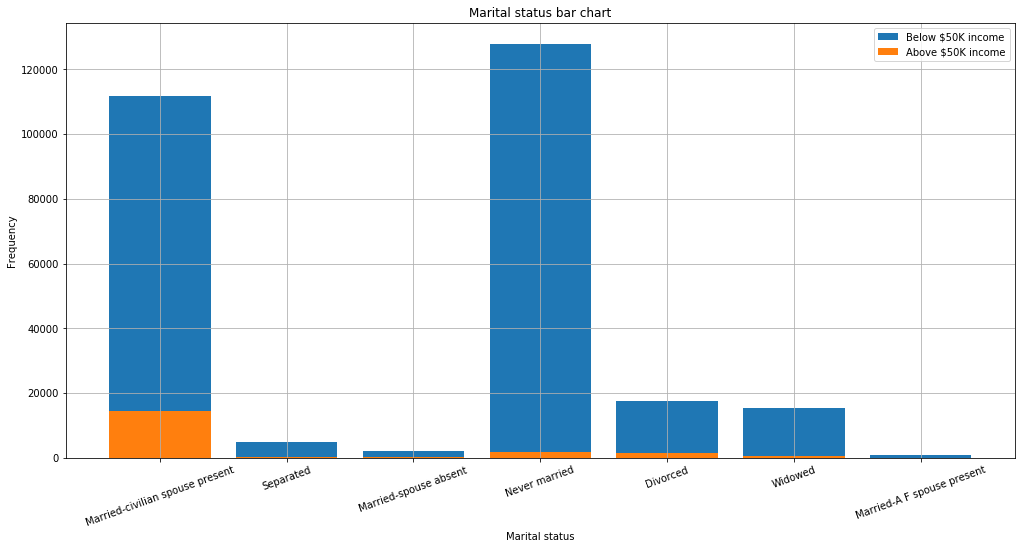

In [31]:
# Query the data
marital_status_count = spark_ds.groupBy('marital_status').agg(
    count(when((col("income") == 0), True)).alias("count0"),
    count(when((col("income") == 1), True)).alias("count1")
)

# count rows labeled 0
marital_status_0_count = [row['count0'] for row in marital_status_count.collect()]
# count rows label 1
marital_status_1_count = [row['count1'] for row in marital_status_count.collect()]
# unique labels
marital_status_labels = [row['marital_status'] for row in marital_status_count.collect()]
index = np.arange(len(marital_status_labels))

# Plot the bar chart
plt.figure(figsize=(17,8))
plt.bar(index, marital_status_0_count, label="Below $50K income")
plt.bar(index, marital_status_1_count, label="Above $50K income")
plt.xticks(index, marital_status_labels, rotation=20)
plt.legend()
plt.grid()
plt.title("Marital status bar chart")
plt.xlabel('Marital status')
plt.ylabel('Frequency')
plt.show()

- Most of the people are "Never married", followed by "Married-Civillian spouse present".
- "Married-Civillian spouse present" has the highest proportion of people with income level 1 (highest orange part).

#### Industry

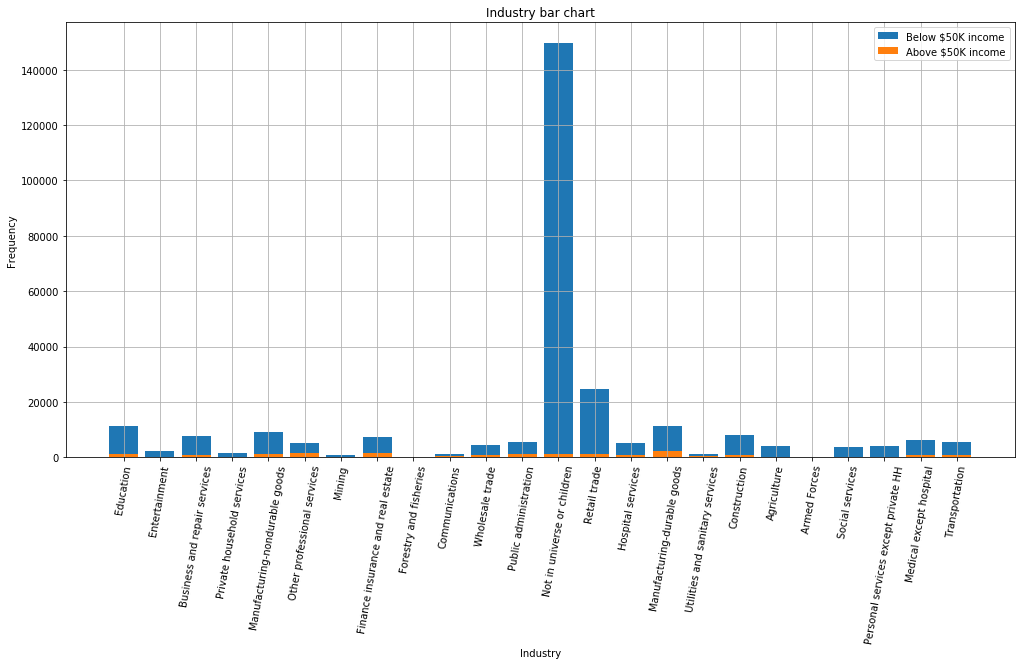

In [32]:
# Query the data
industry_count = spark_ds.groupBy('major_industry_code').agg(
    count(when((col("income") == 0), True)).alias("count0"),
    count(when((col("income") == 1), True)).alias("count1")
)

# count rows labeled 0
industry_0_count = [row['count0'] for row in industry_count.collect()]
# count rows label 1
industry_1_count = [row['count1'] for row in industry_count.collect()]
# unique labels
industry_labels = [row['major_industry_code'] for row in industry_count.collect()]
index = np.arange(len(industry_labels))

# Plot the bar chart
plt.figure(figsize=(17,8))
plt.bar(index, industry_0_count, label="Below $50K income")
plt.bar(index, industry_1_count, label="Above $50K income")
plt.xticks(index, industry_labels, rotation=80)
plt.legend()
plt.grid()
plt.title("Industry bar chart")
plt.xlabel('Industry')
plt.ylabel('Frequency')
plt.show()

- Most of the people taking the survey are "Not in universe or Children".
- The most popular industry is Retail trade with >20K people.
- The industry which has the most proportion of people with income level 1 is "Manufacturing-durable goods".

#### Sex

In [33]:
# Query the data
sex_count = spark_ds.groupBy('sex').agg(
    count(when((col("income") == 0), True)).alias("count0"),
    count(when((col("income") == 1), True)).alias("count1")
)

# count rows labeled 0
sex_0_count = [row['count0'] for row in sex_count.collect()]
# count rows label 1
sex_1_count = [row['count1'] for row in sex_count.collect()]
# unique labels
sex_labels = [row['sex'] for row in sex_count.collect()]
index = np.arange(len(sex_labels))

# Plot the bar chart
plt.figure(figsize=(8,8))
plt.bar(index, sex_0_count, label="Below $50K income")
plt.bar(index, sex_1_count, label="Above $50K income")
plt.xticks(index, sex_labels, rotation=80)
plt.legend()
plt.grid()
plt.title("Sex chart")
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.show()

- There are slightly more females than males taking the survey.
- Males have a higher proportion of people with income level 1 than female.

## Pyspark MLlib process

### Data preprocessing pipelines
The preprocessing pipeline will make sure that the features are converted correctly to be put into the ML classifier. This will include:
1. For numerical columns:  
    1.1. Use **VectorAssembler** to combine numeric columns into vector column "numericFeatures".  
    1.2. Use **StandardScaler** to standardize (z-score) the numeric features.  
2. For categorical columns:  
    2.1. First, use **StringIndexer** to convert categorical columns to be numeric.  
    2.2. Second, use **OneHotEncoderEstimator** to one hot encode the output of (2.1).  
3. Use **VectorAssembler** to combine all columns we have to a single vector column called "features". This will be the input to our ML classifier later.

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# 1. Numerical columns
numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numericFeatures")
scaler = StandardScaler(inputCol="numericFeatures", outputCol="scaledNumericFeatures",
                        withStd=True, withMean=True)

# 2. Categorical columns
# 2.1. StringIndexer
indexers = [StringIndexer(inputCol=c, outputCol="{}_indexed".format(c))
                 for c in nominal_cols]

# 2.1. One hot encode
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
             outputCol="{}_encoded".format(indexer.getOutputCol()), dropLast=False)
             for indexer in indexers]

# 3. Combine into features vector column
final_assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                            + [scaler.getOutputCol()], outputCol="features")

# Execute pipeline on original dataset
preprocessing_pipeline = Pipeline(stages=[numeric_assembler, scaler] + indexers + encoders + [final_assembler])
transformed_ds = preprocessing_pipeline.fit(spark_ds).transform(spark_ds)

# Select only features and label (income) column
transformed_ds = transformed_ds.select("features", "income")
transformed_ds.show(5)

+--------------------+------+
|            features|income|
+--------------------+------+
|(402,[0,9,61,108,...|     0|
|(402,[2,12,67,110...|     0|
|(402,[0,9,61,113,...|     0|
|(402,[0,9,61,109,...|     0|
|(402,[0,9,61,109,...|     0|
+--------------------+------+
only showing top 5 rows



### Train and test set
Originally the dataset has provided us with train and test file but we combine them to perform data exploration analysis + preprocessing. Now we will split them like originally provided.

In [35]:
import pyspark.sql.functions as f
# Add a helper index column
tranformed_ds = transformed_ds.withColumn('index', f.monotonically_increasing_id())

# sort ascending and take first TRAIN_SIZE rows
spark_train = tranformed_ds.sort('index').limit(TRAIN_SIZE).select("features", "income")

# sort descending and TEST_SIZE rows
spark_test = tranformed_ds.sort('index', ascending=False).limit(TEST_SIZE).select("features", "income")

# Verify size
print("Train size:", spark_train.count())
print("Test size:", spark_test.count())

Train size: 199523
Test size: 99762


#### Distribution of label in train and test set

In [36]:
# Distribution of label in train and test set
print("Label distribution in train set:")
spark_train.groupBy("income")\
                .count()\
                .withColumn("count", col("count") / spark_train.count() * 100)\
                .orderBy(desc("count")).show()

print("Label distribution in test set")
spark_test.groupBy("income")\
                .count()\
                .withColumn("count", col("count") / spark_test.count() * 100)\
                .orderBy(desc("count")).show()

Label distribution in train set:
+------+-----------------+
|income|            count|
+------+-----------------+
|     0|93.79419916500854|
|     1|6.205800834991455|
+------+-----------------+

Label distribution in test set
+------+-----------------+
|income|            count|
+------+-----------------+
|     0| 93.7992421964275|
|     1|6.200757803572503|
+------+-----------------+



### Classification Models and Evaluation

#### 1. Logistic Regression

**A. Setup model + train-validation-split hyperparameters tuning**

In [37]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="income", featuresCol="features")

# Tuning evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="income", metricName="areaUnderROC")

# Tuning parameters grid for logistic regression model
lr_param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.1])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter, [10, 100])\
    .build()

# Tuning train-validation-split settings
lr_tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=lr_param_grid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8,
                           parallelism=16)

**B. Train model and predict on test set**

In [38]:
# Run train-validation-split on train set and get the best model
lr_tvs_model = lr_tvs.fit(spark_train)

# Make predictions on test set
lr_predictions = lr_tvs_model.transform(spark_test)

In [39]:
# Best model found:
lr_best = lr_tvs_model.bestModel

print("Logistic Regression model summary:")
# Intercept
print("Intercept:", lr_best.intercept)
# Coefficients
print("Coefficients:")
coefficients = lr_best.coefficients
coefficients = [(float(c),) for c in coefficients]  # convert numpy type to float, and to tuple
coefficients_df = sqlContext.createDataFrame(coefficients, ["Feature Coefficients"])
coefficients_df.show()

# Regularization coefficient
print("Regularization coefficient:", lr_best._java_obj.getRegParam())
# Elastic net coefficient
print("Elastic net coefficient:", lr_best._java_obj.getElasticNetParam())
# Max iteration
print("Max iterations:", lr_best._java_obj.getMaxIter())

Logistic Regression model summary:
Intercept: -4.812434113139641
Coefficients:
+--------------------+
|Feature Coefficients|
+--------------------+
|-0.06457621367048652|
|0.037397415680250186|
| 0.07999605833521022|
|-0.11513954830143898|
|-0.36803201119060036|
|  0.7522815081304506|
|  0.2899830678759263|
| 0.24500796986810075|
| -0.6925150715999165|
|-0.06242846660575597|
|-0.15513211686910555|
|-0.08789082673635368|
| 0.04512236564900362|
|-0.03285919864209153|
| 0.09177901362735659|
|  0.2198403067139889|
| 0.19029892074318275|
|-0.02459076993781...|
| 0.09024032130573534|
| 0.09427083460943102|
+--------------------+
only showing top 20 rows

Regularization coefficient: 0.01
Elastic net coefficient: 0.0
Max iterations: 100


**C. Evaluation Metrics**

In [40]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Get overall statistics (i.e. accuracy, precision, recall and F1-score)
preds_labels_rdd = lr_predictions.rdd.map(lambda x: (float(x.prediction), float(x.income)))
lr_metrics = MulticlassMetrics(preds_labels_rdd)

# Overall statistics
lr_accuracy = lr_metrics.accuracy
# We are interested in the score of precision, recall and F1-score for positive class (few number of samples)
lr_precision = lr_metrics.precision(1.0)
lr_recall = lr_metrics.recall(1.0)
lr_f1Score = lr_metrics.fMeasure(1.0)
print("Logistic Regression summary stats:")
print("Accuracy = {}".format(lr_accuracy))
print("Precision = {}".format(lr_precision))
print("Recall = {}".format(lr_recall))
print("F1 Score = {}".format(lr_f1Score))

Logistic Regression summary stats:
Accuracy = 0.9524468234397867
Precision = 0.7526278906797477
Recall = 0.3472356935014549
F1 Score = 0.475221238938053


#### 2. Decision Tree

**A. Setup model + train-validation-split hyperparameters tuning**

In [41]:
from pyspark.ml.classification import DecisionTreeClassifier
# Create initial DecisionTree model
dt = DecisionTreeClassifier(labelCol="income", 
                            featuresCol="features", 
                            minInstancesPerNode=20)

# Tuning evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="income", metricName="areaUnderROC")

# Tuning parameters grid for decision tree model
dt_param_grid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [15, 20, 30])\
    .addGrid(dt.maxBins, [20, 60])\
    .addGrid(dt.impurity, ['gini', 'entropy'])\
    .build()

# Tuning train-validation-split settings
dt_tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=dt_param_grid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8,
                           parallelism=16)

**B. Train model and predict on test set**

In [42]:
# Run train-validation-split on train set and get the best model
dt_tvs_model = dt_tvs.fit(spark_train)

# Make predictions on test set
dt_predictions = dt_tvs_model.transform(spark_test)

In [43]:
# Best model found:
dt_best = dt_tvs_model.bestModel

print("Decision Tree model summary:")
print("Depth:", dt_best.depth)
print("Number of nodes:", dt_best.numNodes)
print("Impurity criteria:", dt_best._java_obj.getImpurity())
print("Max bins:", dt_best._java_obj.getMaxBins())

Decision Tree model summary:
Depth: 15
Number of nodes: 509
Impurity criteria: entropy
Max bins: 60


**C. Evaluation Metrics**

In [44]:
# Get overall statistics (i.e. accuracy, precision, recall and F1-score)
preds_labels_rdd = dt_predictions.rdd.map(lambda x: (float(x.prediction), float(x.income)))
dt_metrics = MulticlassMetrics(preds_labels_rdd)

# Overall statistics
dt_accuracy = dt_metrics.accuracy
# We are interested in the score of precision, recall and F1-score for positive class (few number of samples)
dt_precision = dt_metrics.precision(1.0)
dt_recall = dt_metrics.recall(1.0)
dt_f1Score = dt_metrics.fMeasure(1.0)
print("Decision Tree summary stats:")
print("Accuracy = {}".format(dt_accuracy))
print("Precision = {}".format(dt_precision))
print("Recall = {}".format(dt_recall))
print("F1 Score = {}".format(dt_f1Score))

Decision Tree summary stats:
Accuracy = 0.9498807161043283
Precision = 0.6619333697433096
Recall = 0.3918525703200776
F1 Score = 0.49228269699431365


#### 3. Random Forest

**A. Setup model + train-validation-split hyperparameters tuning**

In [45]:
from pyspark.ml.classification import RandomForestClassifier
# Create initial RandomForest model
rf = RandomForestClassifier(labelCol="income", 
                            featuresCol="features",
                            impurity="entropy",                          
                            maxDepth=15,
                            maxBins=60,
                            minInstancesPerNode=20)

# Tuning evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="income", metricName="areaUnderROC")

# Tuning parameters grid for random forest model
rf_param_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 30])\
    .build()

# Tuning train-validation-split settings
rf_tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=rf_param_grid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8,
                           parallelism=16)

**B. Train model and predict on test set**

In [46]:
# Run train-validation-split on train set and get the best model
rf_tvs_model = rf_tvs.fit(spark_train)

# Make predictions on test set
rf_predictions = rf_tvs_model.transform(spark_test)

In [47]:
# Best model found:
rf_best = rf_tvs_model.bestModel

print("Random Forest model summary:")
print("Number of trees:", rf_best._java_obj.getNumTrees())

Random Forest model summary:
Number of trees: 20


**C. Evaluation Metrics**

In [48]:
# Get overall statistics (i.e. accuracy, precision, recall and F1-score)
preds_labels_rdd = rf_predictions.rdd.map(lambda x: (float(x.prediction), float(x.income)))
rf_metrics = MulticlassMetrics(preds_labels_rdd)

# Overall statistics
rf_accuracy = rf_metrics.accuracy
# We are interested in the score of precision, recall and F1-score for positive class (few number of samples)
rf_precision = rf_metrics.precision(1.0)
rf_recall = rf_metrics.recall(1.0)
rf_f1Score = rf_metrics.fMeasure(1.0)
print("Random Forest summary stats:")
print("Accuracy = {}".format(rf_accuracy))
print("Precision = {}".format(rf_precision))
print("Recall = {}".format(rf_recall))
print("F1 Score = {}".format(rf_f1Score))

Random Forest summary stats:
Accuracy = 0.9470439646358333
Precision = 0.8597609561752988
Recall = 0.174426123504688
F1 Score = 0.2900147829592797


### Pyspark MLlib result summary

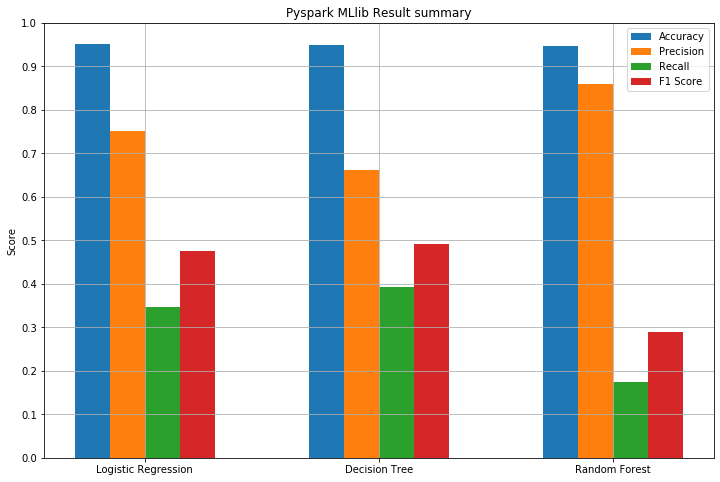

In [49]:
num_models = 3
index = np.arange(num_models)
width = 0.15 # width of bar

# trained models' results
spark_accuracy = [lr_accuracy, dt_accuracy, rf_accuracy]
spark_precision = [lr_precision, dt_precision, rf_precision]
spark_recall = [lr_recall, dt_recall, rf_recall]
spark_f1 = [lr_f1Score, dt_f1Score, rf_f1Score]

# side-by-side bar plot
plt.figure(figsize=(12,8))
plt.bar(index, spark_accuracy, width, label="Accuracy")
plt.bar(index + width, spark_precision, width, label="Precision")
plt.bar(index + width * 2, spark_recall, width, label="Recall")
plt.bar(index + width * 3, spark_f1, width, label="F1 Score")

# Additional info
plt.ylabel("Score")
plt.title("Pyspark MLlib Result summary")
plt.xticks(index + width * 1.5, ('Logistic Regression', 'Decision Tree', 'Random Forest'))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend()
plt.show()

### Convert to pandas dataframe

In [15]:
import pandas as pd
pd.set_option('display.max_columns', 50)
# Pandas dataframe
pd_dataset = spark_ds.toPandas()
# To get train and test set
pd_train_original = pd_dataset.iloc[:TRAIN_SIZE, :]
pd_test_original = pd_dataset.iloc[TRAIN_SIZE:, :]

pd_train_original.shape
pd_test_original.shape

(99762, 31)

In [16]:
pd_dataset.head()

age                 class_of_worker industry_code occupation_code  \
0   73                 Not in universe             0               0   
1   58  Self-employed-not incorporated             4              34   
2   18                 Not in universe             0               0   
3    9                 Not in universe             0               0   
4   10                 Not in universe             0               0   

                    education  wage_per_hr marital_status  \
0        High school graduate          0.0        Widowed   
1  Some college but no degree          0.0       Divorced   
2                  10th grade          0.0  Never married   
3                    Children          0.0  Never married   
4                    Children          0.0  Never married   

           major_industry_code                major_occupation_code  \
0  Not in universe or children                      Not in universe   
1                 Construction  Precision production craft & repair   
2  Not in universe or children                      Not in universe   
3  Not in universe or children                      Not in universe   
4  Not in universe or children                      Not in universe   

                        race hispanic_origin     sex  \
0                      White       All other  Female   
1                      White       All other    Male   
2  Asian or Pacific Islander       All other  Female   
3                      White       All other  Female   
4                      White       All other  Female   

          employment_status  capital_gain  capital_loss  stock_dividends  \
0        Not in labor force           0.0           0.0              0.0   
1  Children or Armed Forces           0.0           0.0              0.0   
2        Not in labor force           0.0           0.0              0.0   
3  Children or Armed Forces           0.0           0.0              0.0   
4  Children or Armed Forces           0.0           0.0              0.0   

    tax_filer_status                          household_status  \
0           Nonfiler  Other Rel 18+ ever marr not in subfamily   
1  Head of household                               Householder   
2           Nonfiler   Child 18+ never marr Not in a subfamily   
3           Nonfiler     Child <18 never marr not in subfamily   
4           Nonfiler     Child <18 never marr not in subfamily   

               household_summary   live_in_this_house_one_year_ago  \
0  Other relative of householder  Not in universe under 1 year old   
1                    Householder                                No   
2              Child 18 or older  Not in universe under 1 year old   
3   Child under 18 never married                               Yes   
4   Child under 18 never married                               Yes   

   num_persons_for_employer                parent birth_country_father  \
0                         0       Not in universe        United-States   
1                         1       Not in universe        United-States   
2                         0       Not in universe              Vietnam   
3                         0  Both parents present        United-States   
4                         0  Both parents present        United-States   

  birth_country_mother birth_country_self                         citizenship  \
0        United-States      United-States   Native- Born in the United States   
1        United-States      United-States   Native- Born in the United States   
2              Vietnam            Vietnam  Foreign born- Not a citizen of U S   
3        United-States      United-States   Native- Born in the United States   
4        United-States      United-States   Native- Born in the United States   

  own_business veteran_benefits  weeks_worked_in_yr year  income  
0            0                2                   0   95       0  
1            0                2                  52   94       0  
2            0                2

In [17]:
# verify that there are no missing values :)
pd_dataset.isnull().sum().sort_values(ascending=False)

income                             0
capital_loss                       0
class_of_worker                    0
industry_code                      0
occupation_code                    0
education                          0
wage_per_hr                        0
marital_status                     0
major_industry_code                0
major_occupation_code              0
race                               0
hispanic_origin                    0
sex                                0
employment_status                  0
capital_gain                       0
stock_dividends                    0
year                               0
tax_filer_status                   0
household_status                   0
household_summary                  0
live_in_this_house_one_year_ago    0
num_persons_for_employer           0
parent                             0
birth_country_father               0
birth_country_mother               0
birth_country_self                 0
citizenship                        0
o

# ---------------------------------------------------XXXX---------------------------------------------

# Self Implementation Starts 

train_df is the training set and test_df is the test_set

In [53]:
train_df = pd_train_original.rename(columns={"income": "total person income"})
test_df = pd_test_original.rename(columns={"income": "total person income"})

In [54]:
pd_train = pd_train_original.rename(columns={"income": "total person income"})
pd_test = pd_test_original.rename(columns={"income": "total person income"})

In [55]:
train_df.head()

age                 class_of_worker industry_code occupation_code  \
0   73                 Not in universe             0               0   
1   58  Self-employed-not incorporated             4              34   
2   18                 Not in universe             0               0   
3    9                 Not in universe             0               0   
4   10                 Not in universe             0               0   

                    education  wage_per_hr marital_status  \
0        High school graduate          0.0        Widowed   
1  Some college but no degree          0.0       Divorced   
2                  10th grade          0.0  Never married   
3                    Children          0.0  Never married   
4                    Children          0.0  Never married   

           major_industry_code                major_occupation_code  \
0  Not in universe or children                      Not in universe   
1                 Construction  Precision production craft & repair   
2  Not in universe or children                      Not in universe   
3  Not in universe or children                      Not in universe   
4  Not in universe or children                      Not in universe   

                        race hispanic_origin     sex  \
0                      White       All other  Female   
1                      White       All other    Male   
2  Asian or Pacific Islander       All other  Female   
3                      White       All other  Female   
4                      White       All other  Female   

          employment_status  capital_gain  capital_loss  stock_dividends  \
0        Not in labor force           0.0           0.0              0.0   
1  Children or Armed Forces           0.0           0.0              0.0   
2        Not in labor force           0.0           0.0              0.0   
3  Children or Armed Forces           0.0           0.0              0.0   
4  Children or Armed Forces           0.0           0.0              0.0   

    tax_filer_status                          household_status  \
0           Nonfiler  Other Rel 18+ ever marr not in subfamily   
1  Head of household                               Householder   
2           Nonfiler   Child 18+ never marr Not in a subfamily   
3           Nonfiler     Child <18 never marr not in subfamily   
4           Nonfiler     Child <18 never marr not in subfamily   

               household_summary   live_in_this_house_one_year_ago  \
0  Other relative of householder  Not in universe under 1 year old   
1                    Householder                                No   
2              Child 18 or older  Not in universe under 1 year old   
3   Child under 18 never married                               Yes   
4   Child under 18 never married                               Yes   

   num_persons_for_employer                parent birth_country_father  \
0                         0       Not in universe        United-States   
1                         1       Not in universe        United-States   
2                         0       Not in universe              Vietnam   
3                         0  Both parents present        United-States   
4                         0  Both parents present        United-States   

  birth_country_mother birth_country_self                         citizenship  \
0        United-States      United-States   Native- Born in the United States   
1        United-States      United-States   Native- Born in the United States   
2              Vietnam            Vietnam  Foreign born- Not a citizen of U S   
3        United-States      United-States   Native- Born in the United States   
4        United-States      United-States   Native- Born in the United States   

  own_business veteran_benefits  weeks_worked_in_yr year  total person income  
0            0                2                   0   95                    0  
1            0                2                  52   94                

In [56]:
train_df_ = pd_train.pop('total person income') # store the labels separately
train_df=pd.DataFrame(data=pd.get_dummies(pd_train, dtype=float))
train_df['total person income'] = train_df_ 

# convert int64 and int32 columns to float64 for logestic regression
cols = train_df.select_dtypes(include=['int64', 'int32']).columns.to_list()
train_df[cols]=train_df[cols].astype('float64')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Columns: 403 entries, age to total person income
dtypes: float64(403)
memory usage: 613.5 MB


In [57]:
train_df.head()

age  wage_per_hr  capital_gain  capital_loss  stock_dividends  \
0  73.0          0.0           0.0           0.0              0.0   
1  58.0          0.0           0.0           0.0              0.0   
2  18.0          0.0           0.0           0.0              0.0   
3   9.0          0.0           0.0           0.0              0.0   
4  10.0          0.0           0.0           0.0              0.0   

   num_persons_for_employer  weeks_worked_in_yr  \
0                       0.0                 0.0   
1                       1.0                52.0   
2                       0.0                 0.0   
3                       0.0                 0.0   
4                       0.0                 0.0   

   class_of_worker_Federal government  class_of_worker_Local government  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   

   class_of_worker_Never worked  class_of_worker_Not in universe  \
0                           0.0                              1.0   
1                           0.0                              0.0   
2                           0.0                              1.0   
3                           0.0                              1.0   
4                           0.0                              1.0   

   class_of_worker_Private  class_of_worker_Self-employed-incorporated  \
0                      0.0                                         0.0   
1                      0.0                                         0.0   
2                      0.0                                         0.0   
3                      0.0                                         0.0   
4                      0.0                                         0.0   

   class_of_worker_Self-employed-not incorporated  \
0                                             0.0   
1                                             1.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   class_of_worker_State government  class_of_worker_Without pay  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   industry_code_0  industry_code_1  industry_code_10  industry_code_11  \
0              1.0              0.0               0.0               0.0   
1              0.0              0.0               0.0               0.0   
2              1.0              0.0               0.0               0.0   
3              1.0              0.0               0.0               0.0   
4              1.0              0.0               0.0               0.0   

   industry_code_12  industry_code_13  industry_code_14  industry_code_15  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   industry_code_16  ...  birth_country_self_Poland  \
0               0.0  ...                        0.0   
1               0.0  ...                        0.0   
2               0.0  ...                        0.0   
3               0.0  ...                        0.0   
4               0.0  ...                        0.0   

   b

In [58]:
test_df_ = pd_test.pop('total person income') # store the labels separately
test_df = pd.DataFrame(data=pd.get_dummies(pd_test, dtype=float))
test_df['total person income'] = test_df_ 

In [59]:
test_df.head()

age  wage_per_hr  capital_gain  capital_loss  stock_dividends  \
199523   38          0.0           0.0           0.0              0.0   
199524   44          0.0           0.0           0.0           2500.0   
199525    2          0.0           0.0           0.0              0.0   
199526   35          0.0           0.0           0.0              0.0   
199527   49          0.0           0.0           0.0              0.0   

        num_persons_for_employer  weeks_worked_in_yr  \
199523                         4                  12   
199524                         1                  26   
199525                         0                   0   
199526                         5                  52   
199527                         4                  50   

        class_of_worker_Federal government  class_of_worker_Local government  \
199523                                 0.0                               0.0   
199524                                 0.0                               0.0   
199525                                 0.0                               0.0   
199526                                 0.0                               0.0   
199527                                 0.0                               0.0   

        class_of_worker_Never worked  class_of_worker_Not in universe  \
199523                           0.0                              0.0   
199524                           0.0                              0.0   
199525                           0.0                              1.0   
199526                           0.0                              0.0   
199527                           0.0                              0.0   

        class_of_worker_Private  class_of_worker_Self-employed-incorporated  \
199523                      1.0                                         0.0   
199524                      0.0                                         0.0   
199525                      0.0                                         0.0   
199526                      1.0                                         0.0   
199527                      1.0                                         0.0   

        class_of_worker_Self-employed-not incorporated  \
199523                                             0.0   
199524                                             1.0   
199525                                             0.0   
199526                                             0.0   
199527                                             0.0   

        class_of_worker_State government  class_of_worker_Without pay  \
199523                               0.0                          0.0   
199524                               0.0                          0.0   
199525                               0.0                          0.0   
199526                               0.0                          0.0   
199527                               0.0                          0.0   

        industry_code_0  industry_code_1  industry_code_10  industry_code_11  \
199523              0.0              0.0               0.0               0.0   
199524              0.0              0.0               0.0               0.0   
199525              1.0              0.0               0.0               0.0   
199526              0.0              0.0               0.0               0.0   
199527              0.0              0.0               0.0               0.0   

        industry_code_12  industry_code_13  industry_code_14  \
199523               0.0               0.0               0.0   
199524               0.0               0.0               0.0   
199525               0.0               0.0               0.0   
199526               0.0               0.0               0.0   
199527               0.0               0.0               0.0   

        industry_code_15  industry_code_16  ...  birth_country_self_Poland  \
199523               0.0               0.0  ...                        0.0   
199524               0.0   

In [60]:
np.seterr(divide='ignore', invalid='ignore') # handle for recorveing from exceptions
X_df =train_df.iloc[:,:-1] # the input parameters for logestic regression
X = X_df.values 
y_ = train_df.iloc[:,-1] # the target labels
y = y_  
y_test = test_df.iloc[:,-1] # test labels

### Logistic Regression

In [61]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        sig = np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))
        sig = np.minimum(sig, 0.99)  # Set upper bound
        sig = np.maximum(sig, 0.01)
        return sig
        #return  np.exp(z)/(np.exp(z) + 1) #1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
           # z= (z_ - min(z_))/(max(z_)-min(z_))
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            if(i % 100 == 0):
                z = np.dot(X, self.theta)
                #z= (z_ - min(z_))/(max(z_)-min(z_))
                h = self.__sigmoid(z)
                print(f'loss: {self.__loss(h, y)} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        #print(self.__sigmoid(np.dot(X, self.theta)))
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [62]:
model = LogisticRegression(lr=0.001, num_iter=400)

In [63]:
model.fit(X, y)

c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


loss: 0.5992964351616391 	


c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


loss: 0.47782766248368364 	
loss: 0.45927104143102504 	
loss: 0.4103338312030317 	


In [64]:
preds = model.predict(test_df, threshold = 0.5)


c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [65]:
y_pred = preds.astype(int)

In [66]:
(y_pred ==y_test).mean()

0.9221346805396845

### Stats


In [67]:
cm_logestic = np.zeros((2, 2), dtype=int)
np.add.at(cm_logestic, [y_test, y_pred], 1)


c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [68]:
print(pd.DataFrame(cm_logestic)) # confusion matrix

       0     1
0  90811  2765
1   5003  1183


In [69]:
#recall
recall_zero_lg =  cm_logestic[0][0]/ (cm_logestic[0][0] +cm_logestic[0][1])
recall_one_lg = cm_logestic[1][1]/ (cm_logestic[1][0] +cm_logestic[1][1])

#precision
precision_zero_lg =  cm_logestic[0][0]/ (cm_logestic[0][0] +cm_logestic[1][0])
precision_one_lg = cm_logestic[1][1]/ (cm_logestic[0][1] +cm_logestic[1][1])

#f1 score
f1_score_zero_lg = 2* ((precision_zero_lg * recall_zero_lg)/ (precision_zero_lg + recall_zero_lg))
f1_score_one_lg = 2* ((precision_one_lg * recall_one_lg)/ (recall_one_lg + precision_one_lg))

#accuracy
accuracy_lg = (y_pred ==y_test).mean()

# Naive Bayes

In [70]:
pd_train.head()

age                 class_of_worker industry_code occupation_code  \
0   73                 Not in universe             0               0   
1   58  Self-employed-not incorporated             4              34   
2   18                 Not in universe             0               0   
3    9                 Not in universe             0               0   
4   10                 Not in universe             0               0   

                    education  wage_per_hr marital_status  \
0        High school graduate          0.0        Widowed   
1  Some college but no degree          0.0       Divorced   
2                  10th grade          0.0  Never married   
3                    Children          0.0  Never married   
4                    Children          0.0  Never married   

           major_industry_code                major_occupation_code  \
0  Not in universe or children                      Not in universe   
1                 Construction  Precision production craft & repair   
2  Not in universe or children                      Not in universe   
3  Not in universe or children                      Not in universe   
4  Not in universe or children                      Not in universe   

                        race hispanic_origin     sex  \
0                      White       All other  Female   
1                      White       All other    Male   
2  Asian or Pacific Islander       All other  Female   
3                      White       All other  Female   
4                      White       All other  Female   

          employment_status  capital_gain  capital_loss  stock_dividends  \
0        Not in labor force           0.0           0.0              0.0   
1  Children or Armed Forces           0.0           0.0              0.0   
2        Not in labor force           0.0           0.0              0.0   
3  Children or Armed Forces           0.0           0.0              0.0   
4  Children or Armed Forces           0.0           0.0              0.0   

    tax_filer_status                          household_status  \
0           Nonfiler  Other Rel 18+ ever marr not in subfamily   
1  Head of household                               Householder   
2           Nonfiler   Child 18+ never marr Not in a subfamily   
3           Nonfiler     Child <18 never marr not in subfamily   
4           Nonfiler     Child <18 never marr not in subfamily   

               household_summary   live_in_this_house_one_year_ago  \
0  Other relative of householder  Not in universe under 1 year old   
1                    Householder                                No   
2              Child 18 or older  Not in universe under 1 year old   
3   Child under 18 never married                               Yes   
4   Child under 18 never married                               Yes   

   num_persons_for_employer                parent birth_country_father  \
0                         0       Not in universe        United-States   
1                         1       Not in universe        United-States   
2                         0       Not in universe              Vietnam   
3                         0  Both parents present        United-States   
4                         0  Both parents present        United-States   

  birth_country_mother birth_country_self                         citizenship  \
0        United-States      United-States   Native- Born in the United States   
1        United-States      United-States   Native- Born in the United States   
2              Vietnam            Vietnam  Foreign born- Not a citizen of U S   
3        United-States      United-States   Native- Born in the United States   
4        United-States      United-States   Native- Born in the United States   

  own_business veteran_benefits  weeks_worked_in_yr year  
0            0                2                   0   95  
1            0                2                  52   94  
2            0                2                   0   9

In [71]:
#refresh data
pd_train = pd_train_original.rename(columns={"income": "total person income"})
pd_test = pd_test_original.rename(columns={"income": "total person income"})
df_test = pd_test
df_one = pd_train.loc[pd_train['total person income'] == 1] # split data according to class labels
df_zero = pd_train.loc[pd_train['total person income'] == 0]



In [72]:
#create posterior probability in dictionary
column_dict_one = {}
column_dict_zero = {}
df_one= df_one.drop(columns='total person income')
df_zero= df_zero.drop(columns='total person income')
for columns in df_one.columns:
    d = df_one.groupby(columns).size()
    prob_dict = {}
    for i in range(len(d.keys())):
        prob_dict[d.keys()[i]] = d.values[i]/len(df_one)
       # print(d2[1])
    column_dict_one[columns] = prob_dict

    
for columns in df_zero.columns:
    d = df_zero.groupby(columns).size()
    prob_dict = {}
    for i in range(len(d.keys())):
        prob_dict[d.keys()[i]] = d.values[i]/ len(df_zero)
       # print(d2[1])
    column_dict_zero[columns] = prob_dict
    


In [73]:
#calclulate class probabilities
n_greater_income = pd_train['total person income'][pd_train['total person income'] == 1].count()
n_lower_income = pd_train['total person income'][pd_train['total person income'] == 0].count()
total_rows = pd_train['total person income'].count()

p_greater_income = n_greater_income/total_rows
p_lower_income = n_lower_income / total_rows

print('Starting Probability of income of class 1 ', p_greater_income * 100,'%\n'
      "Starting Probability of income of class 0 " , p_lower_income * 100, '%')

Starting Probability of income of class 1  6.205800834991455 %
Starting Probability of income of class 0  93.79419916500854 %


In [74]:
# get the list of training columns
col = pd_train.columns
c =len(col) -1
col = col[:c] 
col

Index(['age', 'class_of_worker', 'industry_code', 'occupation_code',
       'education', 'wage_per_hr', 'marital_status', 'major_industry_code',
       'major_occupation_code', 'race', 'hispanic_origin', 'sex',
       'employment_status', 'capital_gain', 'capital_loss', 'stock_dividends',
       'tax_filer_status', 'household_status', 'household_summary',
       'live_in_this_house_one_year_ago', 'num_persons_for_employer', 'parent',
       'birth_country_father', 'birth_country_mother', 'birth_country_self',
       'citizenship', 'own_business', 'veteran_benefits', 'weeks_worked_in_yr',
       'year'],
      dtype='object')

In [75]:
def calc_prob(example, column_dict,col,prev_prob):
    prob = 0 
    for i in col:
        dictionary = column_dict[i]
        list_of_keys = list(dictionary.keys())
        n = example[i]
        if n in list_of_keys:
            prob += np.log(column_dict[i][n])
        else:
            prob += np.log(1)
    return prob + np.log(prev_prob)



df_test['prob_one'] = df_test.apply(lambda row:calc_prob(row, column_dict_one,col,p_greater_income), axis=1) 
df_test['prob_zero'] = df_test.apply(lambda row:calc_prob(row, column_dict_zero,col, p_lower_income), axis=1)   
df_test['classification'] = np.where((df_test['prob_one'] >= df_test['prob_zero']), 1, 0)
df_test['classification_correct'] = np.where((df_test['total person income'] == df_test['classification']), 1, 0) 
df_test['classification_correct'].mean() * 100

74.95439145165493

In [76]:
y_pred_nb = df_test['classification']
y_test_nb = df_test['total person income']

In [77]:
cm_naiveBayes = np.zeros((2, 2), dtype=int)
np.add.at(cm_naiveBayes, [y_test_nb, y_pred_nb], 1)
print(pd.DataFrame(cm_naiveBayes))

       0      1
0  69280  24296
1    690   5496


c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [78]:
#recall
recall_zero_nb =  cm_naiveBayes[0][0]/ (cm_naiveBayes[0][0] +cm_naiveBayes[0][1])
recall_one_nb = cm_naiveBayes[1][1]/ (cm_naiveBayes[1][0] +cm_naiveBayes[1][1])

#precision
precision_zero_nb =  cm_naiveBayes[0][0]/ (cm_naiveBayes[0][0] +cm_naiveBayes[1][0])
precision_one_nb = cm_naiveBayes[1][1]/ (cm_naiveBayes[0][1] +cm_naiveBayes[1][1])

#f1 score
f1_score_zero_nb = 2* ((precision_zero_nb * recall_zero_nb)/ (precision_zero_nb + recall_zero_nb))
f1_score_one_nb = 2* ((precision_one_nb * recall_one_nb)/ (recall_one_nb + precision_one_nb))

#accuracy
accuracy_nb = (y_pred_nb ==y_test_nb).mean()

# Decision tree

### Helper Functions

In [79]:
# check the class labels of the rows in data, 100% purtiy means all rows belong to same class labels
def check_purity(data):
    classes = data[:,-1]
    unique_classes = np.unique(classes) # check the number of unique classes
    if len(unique_classes)==1:
        return True
    else:
        return False
    
#perform classification on the data
def classify_data(data):
    classes = data[:,-1] #extract the 'class' column
    unique_classes, counts_unique_classes = np.unique(classes, return_counts=True) # check row counts for each class label
    
    #get the class label with the most row in the passed dataset and classify 
    #the data i.e. majority voting classification
    
    index = counts_unique_classes.argmax() 
    classification = unique_classes[index]
    
    return classification

# detemine all the possible splits 
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    
    #loop through all cloumns but the last
    for column_index in range(n_columns - 1):
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        #loop through all the unique values in the column to determine potential split values
        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index-1]
                potential_split= (current_value + previous_value)/2 # take average of consecutive rows to ensure splits
                                                                    # are clean i.e. all values <= previous_values
                                                                    # in one group and all values > previousValues
                                                                    # in another 

                potential_splits[column_index].append(potential_split) # store column index and potentail splits value

    return potential_splits
#splits the data into two groups based on the split_column_values and split column
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]
    
    data_below = data[split_column_values <= split_value] # data below the split_value
    data_above = data[split_column_values > split_value] # data above the split value
    return data_below,data_above

#calculate entropy
def calculate_entropy(data):

    classes = data[:,-1]
    _, counts = np.unique(classes, return_counts=True)
    classes_probabilities = counts/counts.sum()
    entropy = np.sum(classes_probabilities * -np.log2(classes_probabilities)) 
    
    return entropy

#overall entropy calculate by adding entropy of data_above and data_below
def calculate_overall_entropy(data_below, data_above):
  
    n_data_points = len(data_below) +len(data_above)
    p_data_below = len(data_below)/ n_data_points
    p_data_above = len(data_above)/ n_data_points

    overall_entropy = (p_data_below * calculate_entropy(data_below) 
                       + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

# determine best split using infromation gain as criteria
def determine_best_split_information_gain(data,potential_splits):
    prev_information_gain = 0
    parent_entropy = calculate_entropy(data)
    
    #loop through each potentail_splits keys i.e. column index andi its values
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below,data_above = split_data(data,column_index,value)
            current_overall_entropy = calculate_overall_entropy(data_below, 
                                                                data_above)
            new_information_gain = parent_entropy - current_overall_entropy
            
            #print(new_information_gain, '  ', prev_information_gain)
            if new_information_gain >= prev_information_gain:
                prev_information_gain = new_information_gain
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


### Algorithm


In [80]:
#algorithm to build the tree
def decision_tree_algorithm(df,counter=0, min_samples = 30, max_depth=6, method=1):
    #data preparations
    if counter == 0:
        global column_headers, best_split_column
        column_headers = df.columns
        data = df.values
    else:
        data = df
    
    #base case
    if (check_purity(data) or (len(data) < min_samples) or counter == max_depth):
        classification = classify_data(data)
        return classification
    # recursive part
    else:
        counter +=1
        
        #helper functions
        potential_splits = get_potential_splits(data)
        
        #choose split criteria
        # method 1 - information_gain
        # method 2 - variance
        # method 3 - gini
        # method any_other - gain_ratio
        if method == 1:
            split_column,split_value = determine_best_split_information_gain(data, potential_splits)
        elif method == 2:
            split_column,split_value = determine_best_split_variance(data, potential_splits)
        elif method == 3:
            split_column,split_value = determine_best_split_gini(data, potential_splits)
        else:
            split_column,split_value = determine_best_split_gain_ratio(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        #instantiate sub-tree
        feature_name = column_headers[split_column]
        question = "{} <= {}".format(feature_name,split_value)
        sub_tree = {question : []}
        
        #find answers (recursive)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, method)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth,method)
        
        #build the tree
        if(yes_answer == no_answer):
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

### Classificaton Function 

In [81]:
#classify the example row using the tree
def classify_example(example,tree):
    
    #split the node infromations into three parts
    question = list(tree.keys())[0]
    
    if(len(question.split('<=')) == 2):
        feature_name = question.split('<=')[0].strip()
        comparison_operator = '<='
        value = question.split('<=')[1].strip()

    elif(len(question.split('>=')) == 2):
        feature_name = question.split('>=')[0].strip()
        comparison_operator = '>='
        value  = question.split('>=')[1].strip()
    elif(len(question.split('>')) == 2):
        feature_name = question.split('>')[0].strip()
        comparison_operator = '>'
        value = question.split('>')[1].strip()
    elif(len(question.split('<')) == 2):
        feature_name = question.split('<')[0].strip()
        comparison_operator = '<'
        value = question.split('<')[1].strip()
    
   # feature_name, comparison_operator, value = question.split()

    # ask question
    if (example[feature_name] <= float(value)).all():
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    #base case
    if not isinstance(answer, dict):
        return answer
    #recursive part
    else:
        residual_tree = answer
        return classify_example(example, answer)

### Accuracy Function 

In [82]:
# compute accuracy
def calculate_accuracy(df,tree):
    
    df['classification'] = df.apply(classify_example, axis = 1, 
                                    args=(tree,))    # apply to all rows in the df
    
    # if class and classifcation are same then classfication_correct will store 1 or else 0
    # Thus 1 in classfication_correct means correct classification or incorrect classification
    df['classification_correct'] = np.where((df['total person income'] == df['classification']), 1, 0) 
    
    y_pred =  df['classification']
    return df['classification_correct'].mean(), y_pred

### Execution command

In [83]:
#df_data.info()
df_data = pd_train_original.rename(columns={"income": "total person income"})
df_test = pd_test_original.rename(columns={"income": "total person income"})
train_df_ = df_data.pop('total person income')
train_df=pd.DataFrame(data=pd.get_dummies(df_data, dtype=float))
train_df['total person income'] = train_df_
cols = train_df.select_dtypes(include='int64').columns.to_list()
#ne[cols]=ne[cols].apply(pd.to_numeric,  errors='coerce')
train_df[cols]=train_df[cols].astype('float64')
print('Training dataset info\n')
train_df.info()


test_df_ = df_test.pop('total person income')
test_df = pd.DataFrame(data=pd.get_dummies(df_test, dtype=float))
test_df['total person income'] = test_df_
cols = test_df.select_dtypes(include='int64').columns.to_list()
#ne[cols]=ne[cols].apply(pd.to_numeric,  errors='coerce')
test_df[cols]=test_df[cols].astype('float64')
print('\nTesting dataset info\n')
test_df.info()

train_df.columns = train_df.columns.str.lstrip()
test_df.columns = test_df.columns.str.lstrip()
tree_train = train_df
tree_test = test_df

Training dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Columns: 403 entries, age to total person income
dtypes: float64(399), int32(4)
memory usage: 610.4 MB

Testing dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 199523 to 299284
Columns: 402 entries, age to total person income
dtypes: float64(398), int32(4)
memory usage: 304.4 MB


#### Binning of  rows to speed up processing

In [84]:
tree_train = tree_train.apply(lambda x: x.sort_values().values)
tree_train = tree_train.reset_index(drop=True)
row = len(tree_train)
columns = ['age', 'wage_per_hr', 'stock_dividends', 'capital_gain', 'capital_loss']
#columns = tree_train.columns.tolist()
#print(columns)
#each column values are divided into 100 bins
for j in columns:
    minValue = 0
    for i in range(10):
        idMax = int((len(tree_train)/10) * (i +1))
        if(idMax < len(tree_train)):
            tree_train.loc[minValue:idMax, j]=  tree_train.loc[minValue:idMax, j].mean()
        else:
            tree_train.loc[minValue:(row-1), j] = tree_train.loc[minValue:(row-1), j].mean()
        minValue=idMax
cols = tree_train.select_dtypes(include=['int64', 'int32']).columns.to_list()
tree_train[cols]=train_df[cols].astype('float64')

In [85]:
tree_train.age.unique()

array([ 2.7186388 ,  8.89824681, 15.40660042, 22.99019778, 29.97589286,
       35.9994475 , 42.29743407, 49.83768343, 60.87820567, 75.93774762])

In [86]:
tree = decision_tree_algorithm(tree_train,max_depth = 6, method =1)

In [87]:
accuracy, y_pred_dt= calculate_accuracy(tree_test,tree)

In [88]:
y_pred_dt = y_pred_dt.astype(int)

In [89]:
y_test_dt = tree_test['total person income']

In [90]:
cm_decisionTrees = np.zeros((2, 2), dtype=int)
np.add.at(cm_decisionTrees, [y_test_dt, y_pred_dt], 1)
print(pd.DataFrame(cm_decisionTrees))

       0    1
0  93431  145
1   6179    7


c:\users\felt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [91]:
#recall
recall_zero_dt =  cm_decisionTrees[0][0]/ (cm_decisionTrees[0][0] +cm_decisionTrees[0][1])
recall_one_dt = cm_decisionTrees[1][1]/ (cm_decisionTrees[1][0] +cm_decisionTrees[1][1])

#precision
precision_zero_dt =  cm_decisionTrees[0][0]/ (cm_decisionTrees[0][0] +cm_decisionTrees[1][0])
precision_one_dt = cm_decisionTrees[1][1]/ (cm_decisionTrees[0][1] +cm_decisionTrees[1][1])

#f1 score
f1_score_zero_dt = 2* ((precision_zero_dt * recall_zero_dt)/ (precision_zero_dt + recall_zero_dt))
f1_score_one_dt = 2* ((precision_one_dt * recall_one_dt)/ (recall_one_dt + precision_one_dt))

#accuracy
accuracy_dt = accuracy

In [92]:
accuracy_dt

0.9366091297287544

# Plots of Results

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
accuracy_data = (accuracy_dt, accuracy_nb, accuracy_lg)

recall_zero = (recall_zero_dt, recall_zero_nb, recall_zero_lg)
recall_one = (recall_one_dt, recall_one_nb, recall_one_lg)

precision_zero = (precision_zero_dt, precision_zero_nb,precision_zero_lg)
precision_one = (precision_one_dt, precision_one_nb,precision_one_lg)

f1_score_zero = (f1_score_zero_dt, f1_score_zero_nb, f1_score_zero_lg)
f1_score_one = (f1_score_one_dt, f1_score_one_nb, f1_score_one_lg)

# create plot
fig, ax = plt.subplots(figsize=(12,8))
index = np.arange(n_groups)
bar_width = 0.09
opacity = 0.8

rects1 = plt.bar(index, accuracy_data, bar_width,
alpha=opacity,
color='b',
label='Accuracy')

rects2 = plt.bar(index + bar_width, recall_zero, bar_width,
alpha=opacity,
color='g',
label='recall_zero')

rects3 = plt.bar(index + (2*bar_width), recall_one, bar_width,
alpha=opacity,
color='r',
label='recall_one')

rects4 = plt.bar(index + (3*bar_width), precision_zero, bar_width,
alpha=opacity,
color='orange',
label='precision_zero')



rects5 = plt.bar(index + (4*bar_width), precision_one, bar_width,
alpha=opacity,
color='y',
label='precision_one')


rects6 = plt.bar(index + (5*bar_width), f1_score_zero, bar_width,
alpha=opacity,
color='pink',
label='f1_score_zero')


rects7 = plt.bar(index + (6*bar_width), f1_score_one, bar_width,
alpha=opacity,
color='grey',
label='f1_score_one')


# plt.xlabel('Classifier')
plt.ylabel('Scores')
plt.title('Scores by classifier')
plt.xticks(index + (bar_width * 3), ('  Decision_tree', '  Naive Bayes', '       Logestic Regression'))
#plt.legend()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),shadow=True, ncol=2)
plt.tight_layout()
plt.show()

In [96]:
print("Summary stats:")
print(("Decision Tree, Naive Bayes, Logistic Regression"))
print("Accuracy:", accuracy_data)
print("Precision:", precision_one)
print("Recall:", recall_one)
print("F1 score:", f1_score_one)

Summary stats:
Decision Tree, Naive Bayes, Logistic Regression
Accuracy: (0.9366091297287544, 0.7495439145165493, 0.9221346805396845)
Precision: (0.046052631578947366, 0.18447905477980667, 0.299645390070922)
Recall: (0.0011315874555447786, 0.8884578079534433, 0.19123827998706758)
F1 score: (0.0022088987062164724, 0.30552004002445937, 0.23347148213933294)


## Keras implementation

In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from sklearn.metrics import classification_report
from keras import backend as K
from sklearn import metrics

In [21]:
# Pandas dataframe
pd_dataset = spark_ds.toPandas()
# To get train and test set
Train = pd_dataset.iloc[:TRAIN_SIZE, :]
Test = pd_dataset.iloc[TRAIN_SIZE:, :]

## Preprocessing

### Prepare Data

In [22]:
# Create a new df which contains the target label and remove the label from the orignal Train set
yTrain = Train["income"]
del Train["income"]

# Create a new df which contains the target label and remove the label from the orignal Test set
yTest = Test["income"]
del Test["income"]

In [23]:
print(Train.shape)
print(Test.shape)

(199523, 30)
(99762, 30)


### One Hot Encoding

In [24]:
# Converts all Cateogroial colums into numeric columns
xTrain=pd.DataFrame(data=pd.get_dummies(Train, dtype=float))
xTest =pd.DataFrame(data=pd.get_dummies(Test, dtype=float))
print(xTrain.shape)
print(xTest.shape)

(199523, 402)
(99762, 401)


### Remove extra column

In [25]:
# delete extra column in the train set which isnt presnet in the test set.
# this will prevent issues regarding training the model later on.
del xTrain["household_status_Grandchild <18 ever marr not in subfamily"]



In [26]:
print(xTrain.shape)
print(xTest.shape)

(199523, 401)
(99762, 401)


## Common Methods

### Print Classification Report 

In [27]:
def getClassReport(yTest,pred):
    print(classification_report(yTest, pred.round()))
    

### Plot Training vs Test Error

In [28]:
import builtins

def plot_history(hist, key='accuracy'):
    
    plt.figure(figsize=(16,10))
    
    for name, history in hist:
        val = plt.plot(history.epoch, history.history['val_'+key], '--', label=name.title()+'val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(), label=name.title() + 'Train')
        
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_', ' ').title())
        plt.legend()
        plt.xlim([0, builtins.max(history.epoch)])

# Model 1 - MLP

Basic Appoarch: 
 - 3 models (Baseline, smaller & larger) will be evaluated with different amount of nuroens to see which model best pedicts new records with suffering from overfitting.
 - The best model from above will then be tuned in more detail to create the MLP classifiers for this stage

## 1) Baseline Model

This model will act as the baseline and will be compared against a smaller and larger network to identiry the best appoach to avoid the model from being ovefitted.

### Define Baseline Model 

Create and organize the layers of the MLP and also specificy the amount of Neurons per layer. This model has 4 layers:
- Input layer has 401 nodes
- Hidden layer 1 has 30 nodes
- Hidden layer 2 has 30 nodes
- Output layer has 1 node

In [106]:
# Dropout can help a model generalize by randomly setting the output for a given neuron to 0. 
# In setting the output to 0, the cost function becomes more sensitive to neighbouring neurons,
# thus changing the way the weights will be updated during the process of backpropagation.

modelMLPBaseline = Sequential()
modelMLPBaseline.add(Dense(30, input_dim=xTrain.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
modelMLPBaseline.add(Dropout(0.5))
modelMLPBaseline.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
modelMLPBaseline.add(Dropout(0.5))
modelMLPBaseline.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))) # Compare against Logistic activation function

# Inspect the model
print(modelMLPBaseline.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                12060     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 13,021
Trainable params: 13,021
Non-trainable params: 0
_________________________________________________________________
None


### Compile Baseline Model 

This stage helps increase efficiency of the keras model by implementanting an optimization scheme which includes an array of paremeters which are tailored to train this model.
- Loss function: Binary_CrossEntropy
- Optimizer: rmsprop
- Metric: Accuracy


In [107]:
modelMLPBaseline.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'binary_crossentropy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fit Baseline Model

In this stage, The network is trained using the backpropagation algorithm, optimized using rmsprop and the loss function will be binary_crossentropy.
Becuase the backpropagation algorithm is used, we need to declare the following:
- Batch size: 10
- Epochs: 15

In [108]:
# returns a history object which contains a summary of the performance of the model during training.
historyBaseline = modelMLPBaseline.fit(xTrain, yTrain,epochs=15,
                                     validation_data=(xTest,yTest))


Train on 199523 samples, validate on 99762 samples
Epoch 1/15
199523/199523 [==============================] - 17s 83us/step - loss: 1.7287 - accuracy: 0.9321 - binary_crossentropy: 1.6641 - val_loss: 0.1931 - val_accuracy: 0.9409 - val_binary_crossentropy: 0.1845
Epoch 2/15
199523/199523 [==============================] - 27s 133us/step - loss: 0.2242 - accuracy: 0.9408 - binary_crossentropy: 0.2161 - val_loss: 0.1806 - val_accuracy: 0.9441 - val_binary_crossentropy: 0.1728
Epoch 3/15
199523/199523 [==============================] - 15s 75us/step - loss: 0.2216 - accuracy: 0.9407 - binary_crossentropy: 0.2140 - val_loss: 0.1920 - val_accuracy: 0.9411 - val_binary_crossentropy: 0.1842
Epoch 4/15
199523/199523 [==============================] - 14s 69us/step - loss: 0.2191 - accuracy: 0.9407 - binary_crossentropy: 0.2113 - val_loss: 0.1829 - val_accuracy: 0.9441 - val_binary_crossentropy: 0.1754
Epoch 5/15
199523/199523 [==============================] - 15s 75us/step - loss: 0.2147 - 

### Evaluate Baseline Model 

This step evaluates the perforamce of the model agaiasnt an unseen dataset (test set) 

In [109]:
# returns a list of metrics: loss and accuracy 
loss, accuracy, binaryCrossentropy = modelMLPBaseline.evaluate(xTest, yTest)
print("accuracy: ", accuracy)
print("loss: ", loss)
print("binaryCrossentropy: ", binaryCrossentropy)
baseline_accuracy = accuracy

99762/99762 [==============================] - 4s 39us/step
accuracy:  0.9402177333831787
loss:  0.1824586419750307
binaryCrossentropy:  0.1744503676891327


### Prediciton with Baseline Model

retun the possibility of the datarecord being of the first taget label and a classification report which contains information about accucacy, recall, precission and f1 measure

In [110]:
predBaseline = modelMLPBaseline.predict(xTest)
getClassReport(yTest, predBaseline)
print()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93576
           1       0.91      0.04      0.08      6186

    accuracy                           0.94     99762
   macro avg       0.93      0.52      0.52     99762
weighted avg       0.94      0.94      0.91     99762




In [113]:
# Value For Graphs 
print("Baseline model summary stats:")
baselinef1 = metrics.f1_score(yTest, predBaseline.round())
print(baselinef1)

baselineRecall = metrics.recall_score(yTest, predBaseline.round())
print(baselineRecall)

baselinePrecision = metrics.precision_score(yTest, predBaseline.round())
print(baselinePrecision)

Baseline model summary stats:
0.07620817843866172
0.03976721629485936
0.9111111111111111


## 2) Smaller Model

An MLP but with less neurons in each layer:
- Input layer has 401 nodes
- Hidden layer 1 has 4 nodes
- Hidden layer 2 has 4 nodes
- Output layer has 1 node


In [114]:
def buildModelSmall():
    
    modelMLPSmaller = Sequential()
    modelMLPSmaller.add(Dense(4, input_dim=xTrain.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    modelMLPSmaller.add(Dropout(0.5))
    modelMLPSmaller.add(Dense(4, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    modelMLPSmaller.add(Dropout(0.5))
    modelMLPSmaller.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))) # Compare against Logistic activation function

    modelMLPSmaller.compile(loss='binary_crossentropy',
                            optimizer='rmsprop',
                            metrics=['accuracy', 'binary_crossentropy'])
    return modelMLPSmaller

# returns a history object which contains a summary of the performance of the model during training.
modelMLPSmaller=buildModelSmall()
historySmaller = modelMLPSmaller.fit(xTrain, yTrain,epochs=15,
                                     validation_data=(xTest,yTest))

loss, accuracy, binaryCrossentropy = modelMLPSmaller.evaluate(xTest, yTest)
print("accuracy: ", accuracy)
mlp_small_accuracy = accuracy
print("loss: ", loss)
print("binaryCrossentropy: ", binaryCrossentropy)


# print(recall_m(yTest, predSmall))
# print(precision_m(yTest, predSmall))
# print(f1_m(yTest, predSmall))

Train on 199523 samples, validate on 99762 samples
Epoch 1/15
199523/199523 [==============================] - 12s 61us/step - loss: 0.5616 - accuracy: 0.9376 - binary_crossentropy: 0.5526 - val_loss: 0.2070 - val_accuracy: 0.9403 - val_binary_crossentropy: 0.2047
Epoch 2/15
199523/199523 [==============================] - 11s 55us/step - loss: 0.2265 - accuracy: 0.9401 - binary_crossentropy: 0.2242 - val_loss: 0.2048 - val_accuracy: 0.9406 - val_binary_crossentropy: 0.2025
Epoch 3/15
199523/199523 [==============================] - 12s 62us/step - loss: 0.2238 - accuracy: 0.9402 - binary_crossentropy: 0.2213 - val_loss: 0.2017 - val_accuracy: 0.9402 - val_binary_crossentropy: 0.1990
Epoch 4/15
199523/199523 [==============================] - 11s 56us/step - loss: 0.2261 - accuracy: 0.9403 - binary_crossentropy: 0.2237 - val_loss: 0.2030 - val_accuracy: 0.9409 - val_binary_crossentropy: 0.2007
Epoch 5/15
199523/199523 [==============================] - 11s 56us/step - loss: 0.2252 - ac

In [117]:
predSmall = modelMLPSmaller.predict(xTest)
getClassReport(yTest, predSmall)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93576
           1       0.73      0.08      0.14      6186

    accuracy                           0.94     99762
   macro avg       0.84      0.54      0.55     99762
weighted avg       0.93      0.94      0.92     99762



In [118]:
# Value For Graphs 

smallModelf1 = metrics.f1_score(yTest, predSmall.round())
print(smallModelf1)

smallModelRecall = metrics.recall_score(yTest, predSmall.round())
print(smallModelRecall)

smallModelPrecision = metrics.precision_score(yTest, predSmall.round())
print(smallModelPrecision)

0.13741576325813068
0.07581635952150016
0.7328125


## 3) Larger model

This model has more nureons in each layer:
- Input layer has 298 nodes
- Hidden layer 1 has 100 nodes
- Hidden layer 2 has 100 nodes
- Output layer has 100 node

In [119]:
modelMLPLarger = Sequential()
modelMLPLarger.add(Dense(100, input_dim=xTrain.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.01)))
modelMLPLarger.add(Dropout(0.5))
modelMLPLarger.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
modelMLPLarger.add(Dropout(0.5))
modelMLPLarger.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))) # Compare against Logistic activation function

modelMLPLarger.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'binary_crossentropy'])

# returns a history object which contains a summary of the performance of the model during training.
historyLarger = modelMLPLarger.fit(xTrain, yTrain,epochs=15,
                                     validation_data=(xTest,yTest))

Train on 199523 samples, validate on 99762 samples
Epoch 1/15
199523/199523 [==============================] - 19s 97us/step - loss: 1.8340 - accuracy: 0.9313 - binary_crossentropy: 1.6648 - val_loss: 0.1946 - val_accuracy: 0.9416 - val_binary_crossentropy: 0.1790
Epoch 2/15
199523/199523 [==============================] - 20s 99us/step - loss: 0.2515 - accuracy: 0.9391 - binary_crossentropy: 0.2379 - val_loss: 0.1842 - val_accuracy: 0.9411 - val_binary_crossentropy: 0.1722
Epoch 3/15
199523/199523 [==============================] - 20s 100us/step - loss: 0.2466 - accuracy: 0.9396 - binary_crossentropy: 0.2344 - val_loss: 0.2234 - val_accuracy: 0.9385 - val_binary_crossentropy: 0.2114
Epoch 4/15
199523/199523 [==============================] - 20s 100us/step - loss: 0.2383 - accuracy: 0.9397 - binary_crossentropy: 0.2266 - val_loss: 0.1810 - val_accuracy: 0.9440 - val_binary_crossentropy: 0.1702
Epoch 5/15
199523/199523 [==============================] - 20s 98us/step - loss: 0.2400 - 

In [120]:
loss, accuracy, binaryCrossentropy = modelMLPLarger.evaluate(xTest, yTest)
print("accuracy: ", accuracy)
mlp_larger_accuracy = accuracy
print("loss: ", loss)
print("binaryCrossentropy: ", binaryCrossentropy)

99762/99762 [==============================] - 2s 24us/step
accuracy:  0.9406788349151611
loss:  0.19736394905805138
binaryCrossentropy:  0.18586602807044983


In [121]:
predLarge = modelMLPLarger.predict(xTest)
getClassReport(yTest, predLarge)

#Graph Values
largeModelF1 = metrics.f1_score(yTest, predLarge.round())
print(largeModelF1)

largeModelRecall = metrics.recall_score(yTest, predLarge.round())
print(largeModelRecall)

largeModelPrecision = metrics.precision_score(yTest, predLarge.round())
print(largeModelPrecision)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     93576
           1       0.56      0.19      0.29      6186

    accuracy                           0.94     99762
   macro avg       0.76      0.59      0.63     99762
weighted avg       0.92      0.94      0.93     99762

0.2881885975463075
0.19366311024894925
0.5629699248120301


### => Choose MLP larger model with best F1 score.

## Plots

EXPLAIN THE PLOT & WHICH MODEL YOU SHOULD SELECT

In [122]:
plot_history([('baseline',historyBaseline), ('Smaller', historySmaller), ('Larger',historyLarger)])


# Model 2 - Linear Classifier (Logistic Classifier Model)

Creates a Logistic Classifier model with the following parameters:
- number of columns = 2
- feature_columns = 
- optimizer = Ftrl
- Iterations = 1000

## Create a Feature Column and a Input Function, USED FOR MODELS 2 & 3

In [31]:
featureName = "features"
featurecolumns = [tf.feature_column.numeric_column(featureName, shape=[xTrain.shape[1]])]

def input_fn(dataVals, labelVals):
    def fn():
        features = {featureName: tf.constant(dataVals)}
        label = tf.constant(labelVals)
        return features, label
    return fn

## Create, Train and Evaluate the Logistic Classifier Model

In [28]:
# linear classifier model
linearEst = tf.estimator.LinearClassifier(n_classes =2,feature_columns=featurecolumns)

# Train the model
linearEst.train(input_fn=input_fn(xTrain,yTrain), steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Felt\\AppData\\Local\\Temp\\tmps48hzcc9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FAED33D128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variab

In [29]:
# Obrain statistics
accScore = linearEst.evaluate(input_fn=input_fn(xTest,yTest), steps = 1000)

pd.Series(accScore).to_frame()
print(pd.Series(accScore).to_frame())

## INFORMATION FOR PLOTS.
## Run above and found out the Recall and precision values, then sub them in below
# model2_precision = 0.422222
# model2_recall = 0.292308
# model2_f1 = 2*((model2_precision*model2_recall)/(model2_precision+model2_recall))
# print(model2_f1)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-26T06:21:50Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\Felt\AppData\Local\Temp\tmps48hzcc9\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2019-10-26-06:29:27
INFO:tensorflow:Saving dict for global 

In [30]:
logistic_classifier_accuracy = accScore['accuracy']
logistic_classifier_precision = accScore['precision']
logistic_classifier_recall = accScore['recall']
logistic_classifier_f1 = 2 * ((logistic_classifier_precision * logistic_classifier_recall)/(logistic_classifier_precision + logistic_classifier_recall))

print("Model 2 summary stats:")
print("Accuracy = {}".format(logistic_classifier_accuracy))
print("Precision = {}".format(logistic_classifier_precision))
print("Recall = {}".format(logistic_classifier_recall))
print("F1 Score = {}".format(logistic_classifier_f1))

Model 2 summary stats:
Accuracy = 0.9388600587844849
Precision = 0.5086681842803955
Recall = 0.4031684398651123
F1 Score = 0.44981515407562256


# Model 3 - Boosted Tree Classififer

In [32]:
# Create the model
tree = tf.estimator.BoostedTreesClassifier(featurecolumns, train_in_memory=True, n_batches_per_layer=1)

# Train the model
tree.train(input_fn=input_fn(xTrain, yTrain), steps=1000)

# Evaluate the mdodel
result = tree.evaluate(input_fn(xTest, yTest), steps=1000)

pd.Series(result).to_frame()

## INFORMATION FOR PLOTS.
## Run above and found out the Recall and precision values, then sub them in below
# model3_precision = XXXXXXx
# model3_recall = XXXXXX
# model3_f1 = 2*((model3_precision*model3_recall)/(model3_precision+model3_recall))
# print(model3_f1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Felt\\AppData\\Local\\Temp\\tmpbn0lrw98', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000014369288B70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variab

0
accuracy                0.957725
accuracy_baseline       0.937992
auc                     0.953420
auc_precision_recall    0.681028
average_loss            0.110886
label/mean              0.062008
loss                    0.110885
precision               0.749239
prediction/mean         0.061719
recall                  0.477692
global_step           600.000000

In [33]:
result

{'accuracy': 0.95772505,
 'accuracy_baseline': 0.9379916,
 'auc': 0.95342016,
 'auc_precision_recall': 0.68102765,
 'average_loss': 0.11088557,
 'label/mean': 0.062008403,
 'loss': 0.110885486,
 'precision': 0.7492393,
 'prediction/mean': 0.061719306,
 'recall': 0.47769156,
 'global_step': 600}

In [35]:
boosted_tree_accuracy = result['accuracy']
boosted_tree_precision = result['precision']
boosted_tree_recall = result['recall']
boosted_tree_f1 = 2 * ((boosted_tree_precision * boosted_tree_recall)/(boosted_tree_precision + boosted_tree_recall))

print("Boosted tree (model 3) summary stats:")
print("Accuracy = {}".format(boosted_tree_accuracy))
print("Precision = {}".format(boosted_tree_precision))
print("Recall = {}".format(boosted_tree_recall))
print("F1 Score = {}".format(boosted_tree_f1))

Boosted tree (model 3) summary stats:
Accuracy = 0.9577250480651855
Precision = 0.7492393255233765
Recall = 0.47769156098365784
F1 Score = 0.5834155678749084
